这是我对于Unet和attention_YNet的尝试，试着把Ynet用到的处理方式应用到Unet上。

这是第一部分,包含了:
基础导入和工具函数
图像处理类(填充/还原)
数据集类
数据加载器创建函数

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import gc

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import *
from functions.data import SegmentationDataset
from functions.imagePreprocessing import ImagePreprocessor


### 检查imagePreprocessor类的大图预处理模块(可用，可视化效果不错)

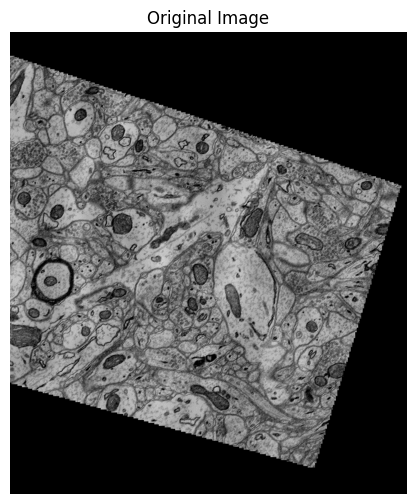

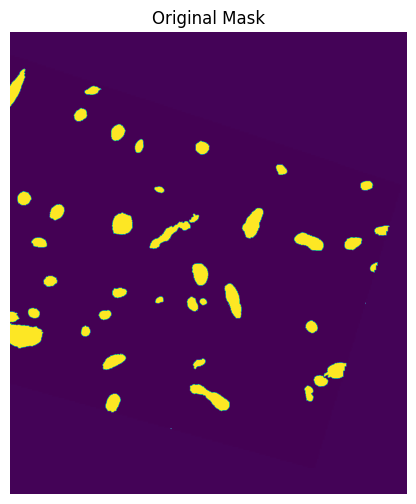

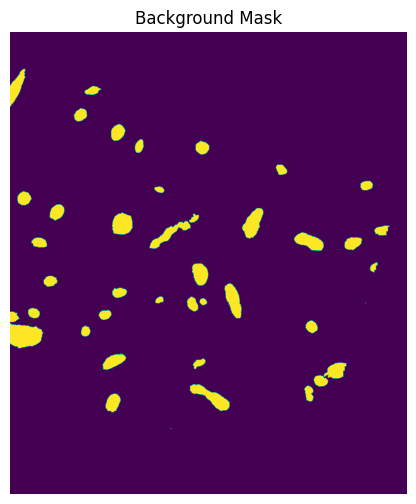

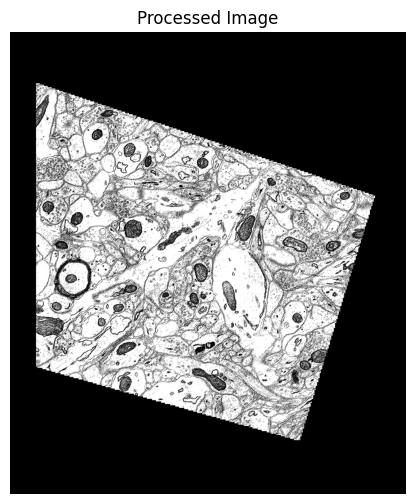

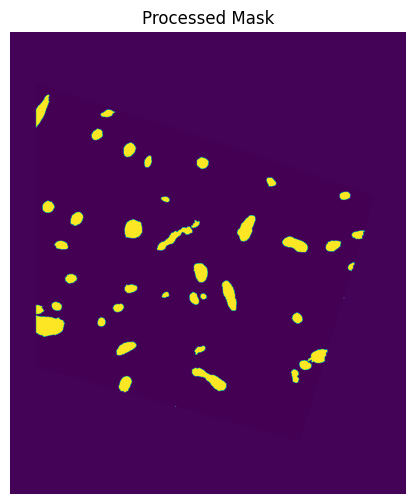

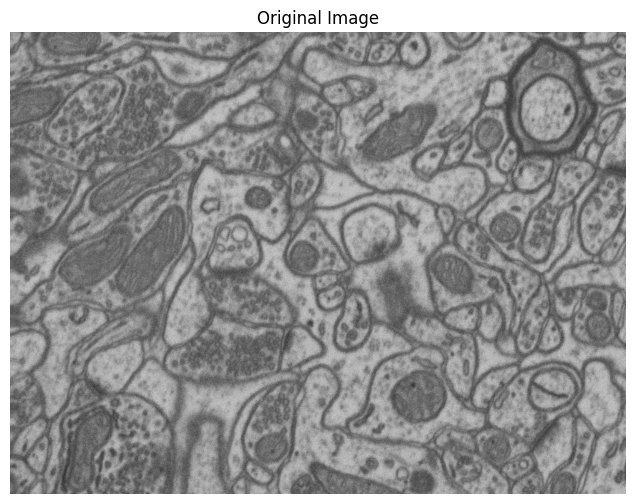

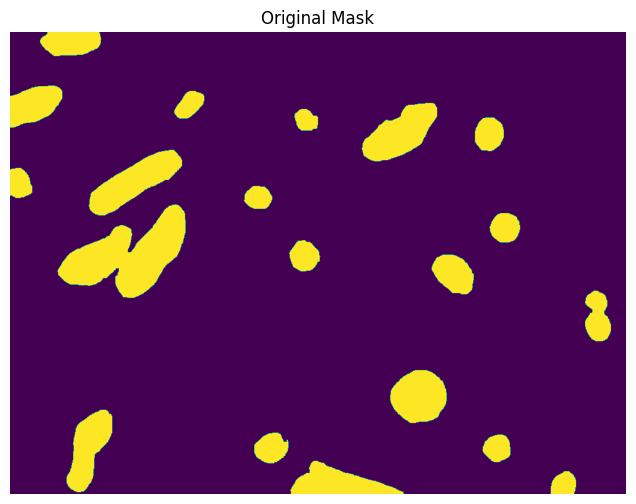

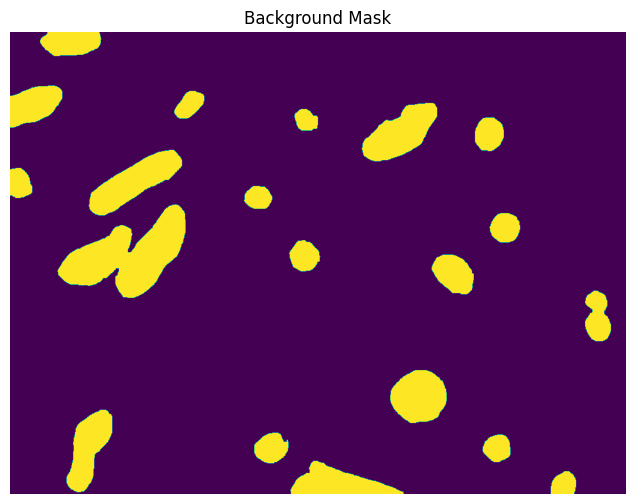

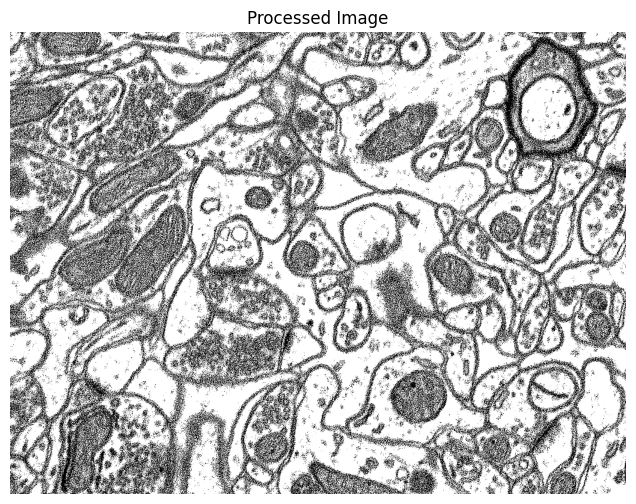

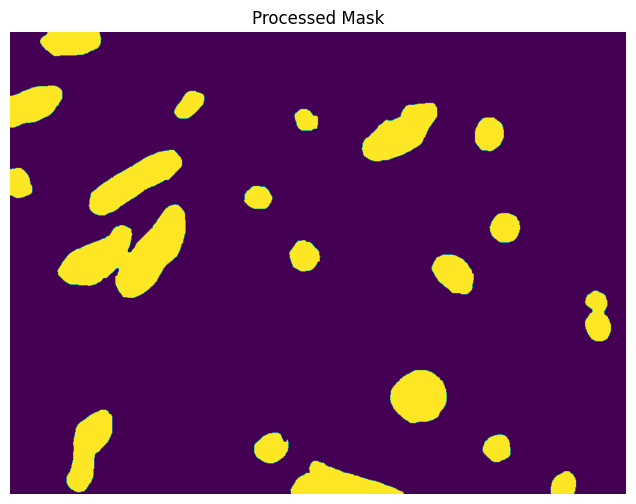

In [3]:
from functions.imagePreprocessing import ImagePreprocessor

# image_path1 = "dataset\Kasthuri++\Test_In\mask1081.png" 
# mask_path1 = "dataset\Kasthuri++\Test_Out\mask1081.png"

#Lucchi++ dataset

image_path2 = "dataset\Lucchi++/Test_In/mask0000.png" 
mask_path2 = "dataset\Lucchi++/Test_Out/0.png"

image_path2 = "dataset\Lucchi++/Test_In/mask0003.png" 
mask_path2 = "dataset\Lucchi++/Test_Out/3.png"

image_path3 = "dataset\Lucchi++\Train_In\mask0002.png" 
mask_path3 = "dataset\Lucchi++\Train_Out/2.png"

patch_size1 = 256
patch_size2 = 256

p = ImagePreprocessor()
processed_image1, processed_mask1,processed_background_mask1 = p.preprocess_show(image_path1, mask_path1, patch_size1,padding=None,value=0,alpha=1.0)
processed_image2, processed_mask2,processed_background_mask2 = p.preprocess_show(image_path2, mask_path2, patch_size2,padding=None,value=0,alpha=1.0)
########

# image = cv2.imread(image_path2)
# mask = cv2.imread(mask_path2, cv2.IMREAD_GRAYSCALE)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# processed_image, processed_mask, params = p.random_preprocess(image, mask, patch_size=256)
# plt.figure(figsize=(20, 8))
            
  
# plt.subplot(1, 2, 1)
# plt.imshow(processed_image)
# plt.title("Processed Image")

# plt.subplot(1, 2, 2)
# plt.imshow(processed_mask)
# plt.title("Processed Mask")

# plt.show()

### 测试dataset的patch分割模块(可用，可视化效果极佳！)

In [5]:
train_data, test_data = prepare_dataset("Kasthuri++") # Lucchi++ /  Kasthuri++ / VNC
PATCH_SIZE = 128 #这个暂时不需要理会，和下面的内容没关系
# # Path to the chest-ct-segmentation dataset folder
# data_dir = "dataset\Lucchi++" 
# train_images_dir = os.path.join(data_dir, "Train_In")
# train_masks_dir = os.path.join(data_dir, "Train_Out")
# test_images_dir = os.path.join(data_dir, "Test_In")
# test_masks_dir = os.path.join(data_dir, "Test_Out")


# i = 0
# # Prepare the training data, Append image and corresponding mask paths
# train_data = []
# for image_file in os.listdir(train_images_dir):
#     image_path = os.path.join(train_images_dir, image_file)
#     mask_path = os.path.join(train_masks_dir, f"{i}.png")
#     i += 1
#     train_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })

# i = 0
# # Prepare the test data, Append image and corresponding mask paths
# test_data = []
# for image_file in os.listdir(test_images_dir):
#     image_path = os.path.join(test_images_dir, image_file)
#     mask_path = os.path.join(test_masks_dir, f"{i}.png")
#     i += 1
#     test_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })
# print(train_data)



Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

In [6]:
# 创建数据集
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=128,                # 可选：patch大小，默认128
    stride=64,                     # 可选：滑动步长，默认64
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

# test_dataset= SegmentationDataset(
#     data_list=train_data,          # 必需：数据列表
#     patch_size=128,                # 可选：patch大小，默认128
#     stride=64,                     # 可选：滑动步长，默认64
#     transform=None                 # 可选：数据增强转换，默认None
# )


开始数据集预处理...


处理图像: 100%|██████████| 85/85 [00:35<00:00,  2.40it/s]

数据集预处理完成，共生成 44513 个patch


数据集信息:
总样本数: 44513
图像块大小: 128x128
滑动步长: 64
是否使用数据增强: 否

数据形状:
图像块形状: torch.Size([3, 128, 128])
掩码块形状: torch.Size([1, 128, 128])

显示图片的patches: mask1062.png
原图路径: dataset\Kasthuri++\Train_In\mask1062.png
对应的Mask路径: dataset\Kasthuri++\Train_Out\mask1062.png
图片索引: 31


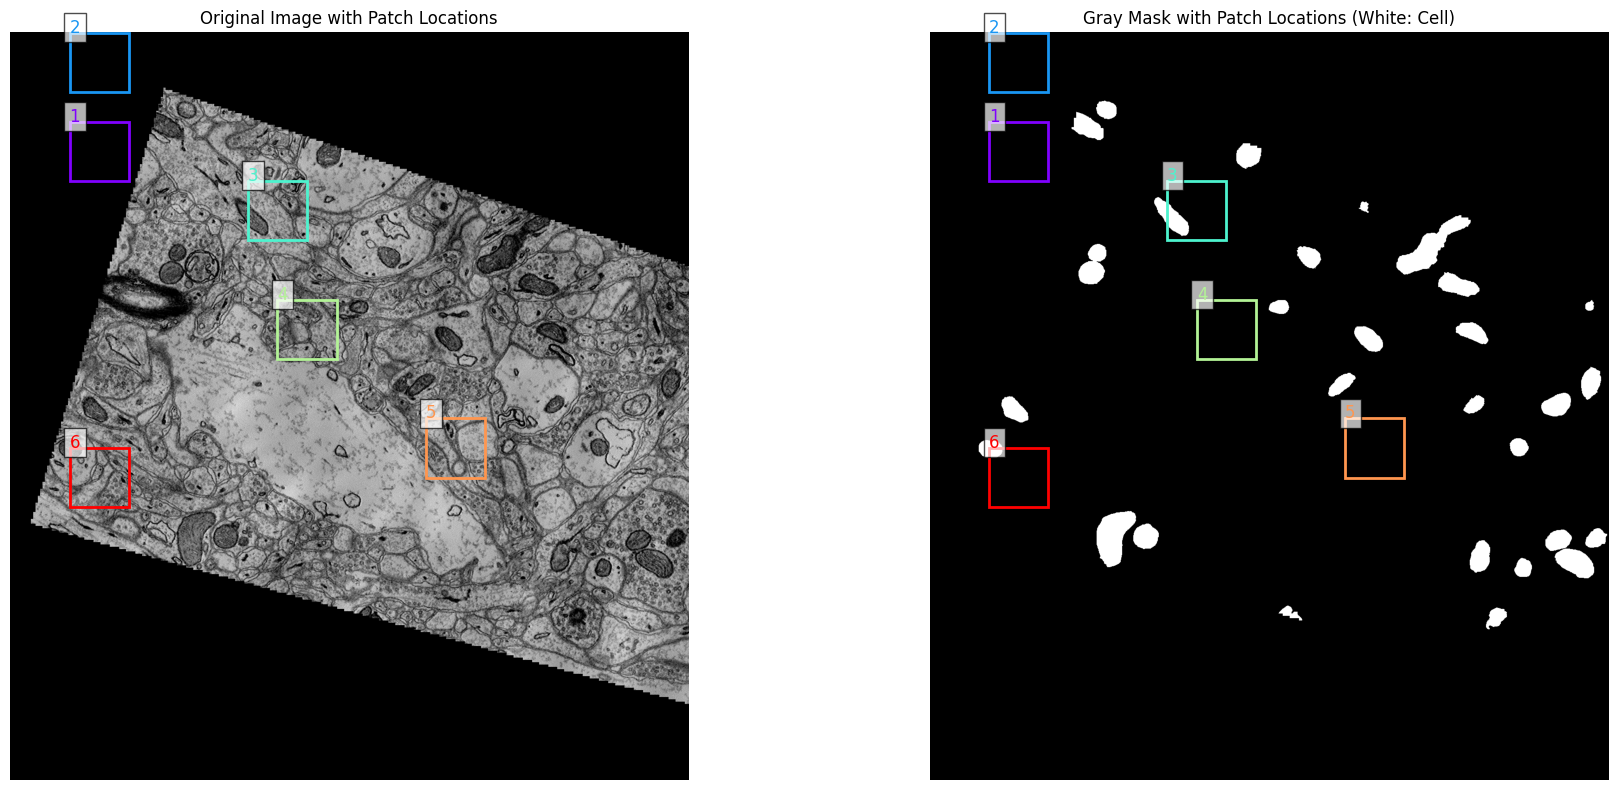

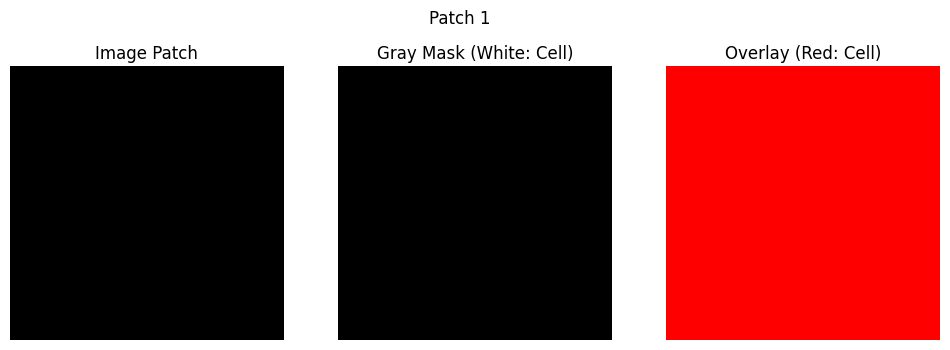

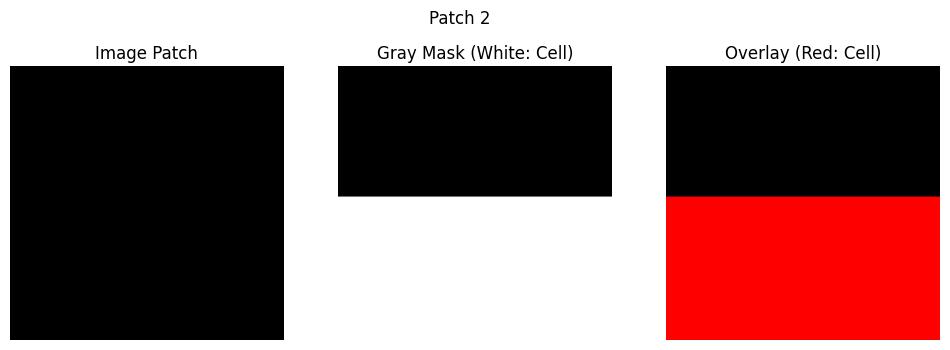

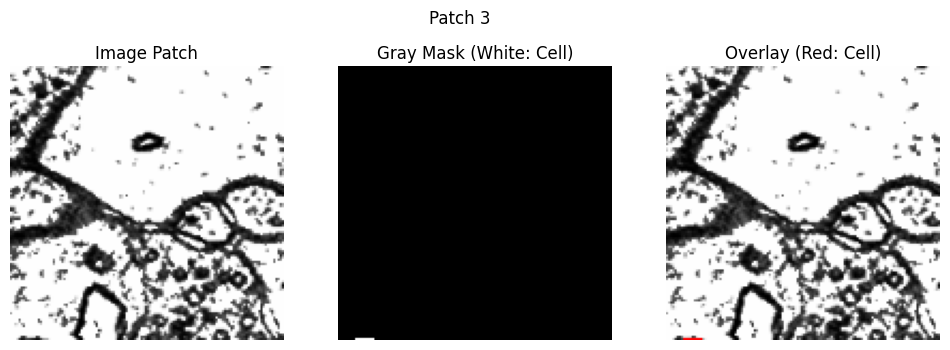

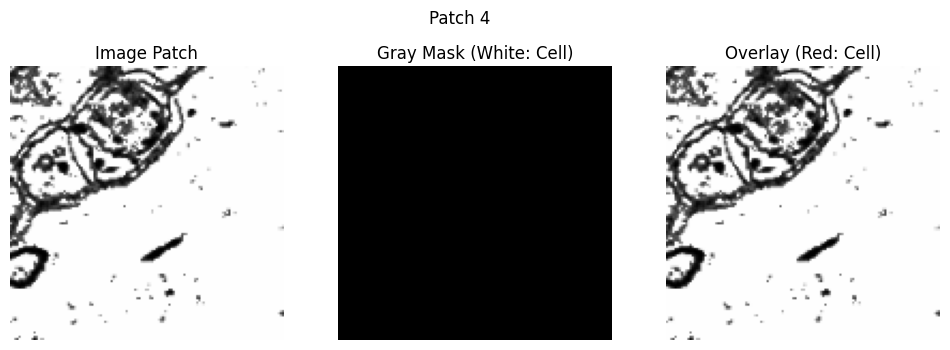

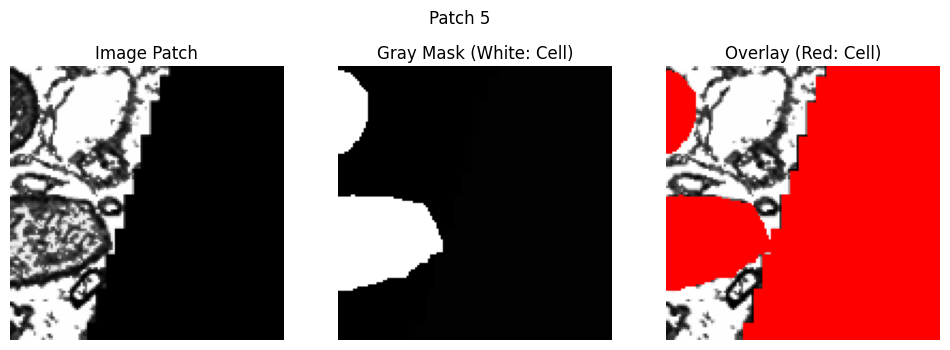

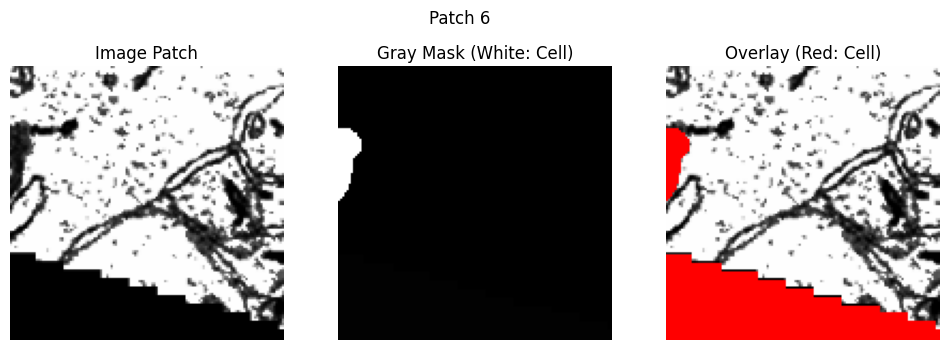

In [7]:
# 打印数据集基本信息
train_dataset.print_dataset_info()

# 随机查看几张图片的patches
train_dataset.visualize_random_images(num_images=1, patches_per_image=6)



### 训练回顾笔记  


   曾经的回顾：2025.0226之前的 测试： train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
patch_size=128, stride=64   


100%|██████████| 1702/1702 [21:33<00:00,  1.32it/s]
Epoch 1/50:
Train Loss: 0.0931, IoU: 0.7630, Dice: 0.8512
Val Loss: 0.0560, IoU: 0.7202, Dice: 0.8242
100%|██████████| 1702/1702 [30:43<00:00,  1.08s/it]
Epoch 2/50:
Train Loss: 0.0175, IoU: 0.9148, Dice: 0.9547
Val Loss: 0.0529, IoU: 0.7448, Dice: 0.8404
100%|██████████| 1702/1702 [30:27<00:00,  1.07s/it]
Epoch 3/50:
Train Loss: 0.0120, IoU: 0.9370, Dice: 0.9672
Val Loss: 0.0635, IoU: 0.7372, Dice: 0.8368

训练：
原始图像/掩码 -> 切分为128x128 patches(stride=64) -> 数据标准化(/255.0) -> 通道转换(HWC->CHW) -> 训练数据集构建
                                                                                                    ↓
                                                                                              模型训练循环
                                                                                                    ↓
                                                                                        保存最佳模型(IoU/Loss)

预测：
输入图像 -> 保持原始尺寸 -> 切分重叠patches(overlap=64) -> 数据标准化和通道转换 -> 模型预测
                                                                                    ↓
                                                            输出完整掩码 <- 加权重建 <- patch级预测结果


可使用counterbalance做对抗，train的部分需要在与处理下保证不同类的数据集特征倾向一致（这个之前没有做好导致泛化效率低）

首要目标：train和test的patch分割，都要使用patch进行，保证重叠度
         train部分的预处理操作不够完善（旋转和缩放没有设置，可能导致斜放图片以及比例不同的图片准确度下降），导致AB类数据集特征倾向不一致，泛化能力差
         后处理部分，目前只进行了形态学的消去小噪点，后续可以进行优化(打点，填充，闭运算等) 
         模块提取 后处理和预处理的内容
         还要加一个打点，这个可以去turnfinesam2那边找，记得把sam的内容也丢进来
        下面的是get point的方法，在 turnfinesam2_fix那边，要注意看！！！！把取点的后处理也拖动到unet中
         def get_points(mask, num_points):  # Sample points inside the input mask
            points = []
            coords = np.argwhere(mask > 0)
            for i in range(num_points):
                yx = np.array(coords[np.random.randint(len(coords))])
                points.append([[yx[1], yx[0]]])
            return np.array(points)
        这个函数可以随机选取mask中点，然后返回，这样偏差会小一些，记住！打点操作是后处理

准备尝试轻量化的数据测试，从1702降下来，看看整体效果，并且虽然加入了patch分割训练，但是还需要添加数据的预处理，比如颜色对比度的normalization，以及数据增强，还有对载入图片旋转训练（可以考虑加入其他数据进行验证，即Lucchi++和Kasthrui++混合训练），图像的后处理部分暂时可以先维持形态学的消去小噪点，后续再进行优化。

核心问题：model基础效果太差导致跨数据测试完全没效果，最大因素或许不在于size，而是颜色以及图片的细胞大小(即图片所占比例)，则测试准确度骤降，这点可以通过VNC和lucchi++数据集进行验证得到的，Lucchi model对VNC的测试甚至不如Kasthrui，但是看图片会发现虽然三类的数据集size都不一样，VNC颜色对比与K接近，而Lucchi偏向于浅色，这点也会影响模型的效果。


### 导入model.py部分内容

In [2]:
from functions.model import load_model
from functions.model import save_model
from functions.model import calculate_metrics
from functions.model import reconstruct_from_patches
from functions.model import train_model
from functions.model import predict


### 下面是我的旧版3.11之前的train内容，用的不是model.py里面的方法而是本地的内容

In [2]:


# 使用例子 model = UNet(num_classes=1).to(device)，下面是原注释

# class SegmentationModel(nn.Module):
#     def __init__(self, num_classes):
#         super(SegmentationModel, self).__init__()
        
#         # Encoder (downsampling)
#         self.encoder = nn.Sequential(
#             self.conv_block(3, 32, stride=2),
#             self.conv_block(32, 64, stride=2),
#             self.conv_block(64, 128, stride=2),
#             self.conv_block(128, 256, stride=2)
#         )
        
#         # Decoder (upsampling)
#         self.decoder = nn.Sequential(
#             self.upconv_block(256, 128),
#             self.upconv_block(128, 64),
#             self.upconv_block(64, 32),
#             self.upconv_block(32, 32)
#         )
        
#         # Final classification layer
#         self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        
#     def conv_block(self, in_channels, out_channels, stride=1):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def upconv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def forward(self, x):
#         # Encoder
#         features = []
#         for encoder_layer in self.encoder:
#             x = encoder_layer(x)
#             features.append(x)
        
#         # Decoder
#         for i, decoder_layer in enumerate(self.decoder):
#             x = decoder_layer(x)
#             if i < len(self.decoder) - 1:
#                 x = x + features[-i-2]  # Skip connection
        
#         # Final classification
#         x = self.final(x)
#         return x

# Custom Dataset class

# class SegmentationDataset(torch.utils.data.Dataset):
#     def __init__(self, data_list, patch_size=128, stride=64, transform=None):
#         self.data_list = data_list
#         self.patch_size = patch_size
#         self.stride = stride
#         self.transform = transform
        
#         # 预处理所有图像的patches
#         self.all_patches = []
#         self.all_masks = []
#         self.all_positions = []
#         self.all_sizes = []
#         self.all_paths = []
        
#         for item in data_list:
#             image = cv2.imread(item["image"])
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             mask = cv2.imread(item["annotation"], cv2.IMREAD_GRAYSCALE)
            
#             patches, mask_patches, positions, original_size = self.process_image_to_patches(image, mask)
            
#             for patch, mask_patch in zip(patches, mask_patches):
#                 if self.transform:
#                     patch = self.transform(patch)
                
#                 patch = torch.FloatTensor(patch.transpose(2, 0, 1)) / 255.0
#                 mask_patch = torch.FloatTensor(mask_patch).unsqueeze(0) / 255.0
                
#                 self.all_patches.append(patch)
#                 self.all_masks.append(mask_patch)
#                 self.all_positions.append(positions)
#                 self.all_sizes.append(original_size)
#                 self.all_paths.append(item["image"])

#     def process_image_to_patches(self, image, mask):
#         """处理图像和掩码为patches"""
#         h, w = image.shape[:2]
#         patches = []
#         mask_patches = []
#         positions = []
        
#         for y in range(0, h-self.patch_size+1, self.stride):
#             for x in range(0, w-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         # 处理边缘情况
#         if h % self.stride != 0:
#             y = h - self.patch_size
#             for x in range(0, w-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         if w % self.stride != 0:
#             x = w - self.patch_size
#             for y in range(0, h-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         if h % self.stride != 0 and w % self.stride != 0:
#             y = h - self.patch_size
#             x = w - self.patch_size
#             patch = image[y:y+self.patch_size, x:x+self.patch_size]
#             mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#             patches.append(patch)
#             mask_patches.append(mask_patch)
#             positions.append((y, x))
        
#         return patches, mask_patches, positions, (h, w)

#     def __len__(self):
#         return len(self.all_patches)

#     def __getitem__(self, idx):
#         return {
#             'patches': self.all_patches[idx],
#             'mask_patches': self.all_masks[idx],
#             'positions': self.all_positions[idx],
#             'original_size': self.all_sizes[idx],
#             'image_path': self.all_paths[idx]
#         } 
    
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    # Convert predictions to binary
    pred_mask = (pred_mask > threshold).float()

    # Calculate intersection and union
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Calculate Dice coefficient
    dice = (2. * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)

    return iou.item(), dice.item()

# Add reconstruction function
# def reconstruct_from_patches(patches, positions, original_size, patch_size, stride):
#     """从patches重建完整图像"""
#     h, w = original_size
#     reconstructed = np.zeros((h, w), dtype=np.float32)
#     count = np.zeros((h, w), dtype=np.float32)
    
#     for patch, (y, x) in zip(patches, positions):
#         patch_h = min(patch_size, h - y)
#         patch_w = min(patch_size, w - x)
#         reconstructed[y:y+patch_h, x:x+patch_w] += patch[:patch_h, :patch_w]
#         count[y:y+patch_h, x:x+patch_w] += 1
    
#     # 处理重叠区域
#     count[count == 0] = 1
#     reconstructed /= count
#     return reconstructed
 

# Training function(删除多余的实时打印避免cpu占用过高和内存过载，gpu利用率提升)
def train_model(model, train_loader, val_loader, num_epochs=50, device="cuda"):
    import gc
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    # 初始清理内存
    if device == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        
        for batch in train_loader:
            patches = batch['patches'].to(device)
            mask_patches = batch['mask_patches'].to(device)
            
            optimizer.zero_grad()
            outputs = model(patches)
            loss = criterion(outputs, mask_patches)
            
            loss.backward()
            optimizer.step()
            
            pred_masks = torch.sigmoid(outputs) > 0.5
            iou, dice = calculate_metrics(pred_masks.float(), mask_patches)
            
            train_loss += loss.item()
            train_iou += iou
            train_dice += dice
            
            # 释放不需要的临时变量
            del patches, mask_patches, outputs, pred_masks, loss
        
        # 计算平均值
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        
        # 训练完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device)
                mask_patches = batch['mask_patches'].to(device)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = torch.sigmoid(outputs) > 0.5
                iou, dice = calculate_metrics(pred_masks.float(), mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
                
                # 释放不需要的临时变量
                del patches, mask_patches, outputs, pred_masks, loss
        
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_dice /= len(val_loader)
        
        # 验证完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 简洁输出格式
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        print('------------------------------------------------------------')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')
        
        # 保存模型后再次清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
 
#Training function optimized at 2025.3.5 --16:21  （这两种train方法暂时不知道哪个好）
def optimized_train_model(model, train_loader, val_loader, num_epochs=50, device="cuda", 
                          batch_accumulation=1, pin_memory=True):
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    # 设置异步数据加载
    train_loader.pin_memory = pin_memory
    val_loader.pin_memory = pin_memory
    
    # 初始清理内存
    if device == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        batch_count = 0
        
        optimizer.zero_grad()  # 外部清零梯度
        
        for batch_idx, batch in enumerate(train_loader):
            # 使用梯度累积减少GPU内存使用
            patches = batch['patches'].to(device, non_blocking=True)
            mask_patches = batch['mask_patches'].to(device, non_blocking=True)
            
            outputs = model(patches)
            loss = criterion(outputs, mask_patches) / batch_accumulation
            
            loss.backward()
            
            # 梯度累积：每累积batch_accumulation个批次更新一次权重
            if (batch_idx + 1) % batch_accumulation == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            iou, dice = calculate_metrics(pred_masks, mask_patches)
            
            train_loss += loss.item() * batch_accumulation
            train_iou += iou
            train_dice += dice
            batch_count += 1
            
            # 在内部也进行内存清理
            del patches, mask_patches, outputs, pred_masks, loss
            
            # 定期清理GPU内存
            if batch_idx % 10 == 0 and device == "cuda":
                torch.cuda.empty_cache()
        
        # 处理剩余的梯度
        if batch_count % batch_accumulation != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # 计算平均值
        train_loss /= batch_count
        train_iou /= batch_count
        train_dice /= batch_count
        
        # 训练完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_count = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device, non_blocking=True)
                mask_patches = batch['mask_patches'].to(device, non_blocking=True)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                iou, dice = calculate_metrics(pred_masks, mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
                val_count += 1
                
                del patches, mask_patches, outputs, pred_masks, loss
        
        val_loss /= val_count
        val_iou /= val_count
        val_dice /= val_count
        
        # 验证完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 简洁输出格式
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        print('------------------------------------------------------------')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_iou.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')   
            

# 优化后预测函数 2025.3.5 --18:21
def reconstruct_from_patches(patches, positions, original_size, patch_size, stride):
    """
    从patches重建完整图像
    
    参数:
        patches: 预测的patch列表
        positions: 每个patch的左上角坐标列表，格式为[(y1, x1), (y2, x2), ...]
        original_size: 原始图像尺寸，格式为(height, width)
        patch_size: patch的大小
        stride: patch滑动的步长

    返回:
        reconstructed: 重建后的完整图像
    """
    h, w = original_size
    reconstructed = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)
    
    for patch, (y, x) in zip(patches, positions):
        patch_h = min(patch_size, h - y)
        patch_w = min(patch_size, w - x)
        reconstructed[y:y+patch_h, x:x+patch_w] += patch[:patch_h, :patch_w]
        count[y:y+patch_h, x:x+patch_w] += 1
    
    # 处理重叠区域
    count[count == 0] = 1
    reconstructed /= count
    return reconstructed
# 优化后预测函数 2025.3.5 --18:21
# def predict(model, image_path, mask_path=None, device="cuda", save_dir="test/predictData", patch_size=256, stride=None, value=-30, alpha=1.3):
#     """
#     完整的预测流程：读取图像、预处理、预测、保存结果
    
#     参数:
#         model: 训练好的模型
#         image_path: 图像路径
#         mask_path: 掩码路径，可选
#         device: 使用的设备，默认为cuda
#         save_dir: 保存结果的目录
#         patch_size: 处理的patch大小
#         stride: patch滑动的步长，None则默认为patch_size//2
#         value: 亮度调整值
#         alpha: 对比度调整系数
    
#     返回:
#         pred_mask: 预测的分割掩码
#     """
#     # 设置默认stride
#     if stride is None:
#         stride = patch_size // 2  # 默认50%重叠
    
#     # 确保保存目录存在
#     os.makedirs(save_dir, exist_ok=True)
    
#     # 提取文件名（不含扩展名）作为保存前缀
#     file_name = os.path.splitext(os.path.basename(image_path))[0]
    
#     # 1. 读取原始图像
#     orig_image = cv2.imread(image_path)
#     orig_image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    
#     # 保存原始图像尺寸
#     orig_h, orig_w = orig_image.shape[:2]
    
#     # 2. 读取原始mask（如果提供）
#     orig_mask = None
#     if mask_path and os.path.exists(mask_path):
#         orig_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
#     # # 3. 执行预处理，使用与训练时完全相同的预处理流程
#     # preprocessor = ImagePreprocessor()
    
#     # # 调用与训练时完全相同的预处理方法
#     # processed_image, processed_mask = preprocessor.preprocess(
#     #     orig_image_rgb, 
#     #     orig_mask,
#     #     patch_size=patch_size,
#     #     value=value,
#     #     alpha=alpha
#     # )
    
#     #3.28新增
#     processed_image = orig_image_rgb
#     processed_mask = orig_mask
    
#     # 计算填充信息（比较预处理前后的尺寸变化）
#     processed_h, processed_w = processed_image.shape[:2]
    
#     # 计算每边的填充像素数
#     h_diff = processed_h - orig_h
#     w_diff = processed_w - orig_w
    
#     # 对称填充情况下：
#     top_pad = h_diff // 2
#     bottom_pad = h_diff - top_pad
#     left_pad = w_diff // 2
#     right_pad = w_diff - left_pad
    
#     padding_info = (top_pad, bottom_pad, left_pad, right_pad)
    
#     # 4. 保存原始和预处理数据
#     # 原始图像
#     cv2.imwrite(os.path.join(save_dir, f"{file_name}_original.png"), orig_image)
    
#     # 原始mask（如果存在）
#     if orig_mask is not None:
#         cv2.imwrite(os.path.join(save_dir, f"{file_name}_original_mask.png"), orig_mask)
    
#     # 预处理后的图像
#     processed_image_bgr = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)
#     cv2.imwrite(os.path.join(save_dir, f"{file_name}_processed.png"), processed_image_bgr)
    
#     # 预处理后的mask（如果存在）
#     if processed_mask is not None:
#         # 将浮点mask转换为8位灰度图像
#         if processed_mask.dtype != np.uint8:
#             processed_mask_save = (processed_mask * 255).astype(np.uint8)
#         else:
#             processed_mask_save = processed_mask
#         cv2.imwrite(os.path.join(save_dir, f"{file_name}_processed_mask.png"), processed_mask_save)
    
#     # 5. 执行预测
#     model.eval()
    
#     # 获取当前处理图像的尺寸
#     current_h, current_w = processed_image.shape[:2]
    
#     # 计算步数
#     h_steps = max(1, (current_h - patch_size + stride) // stride)
#     w_steps = max(1, (current_w - patch_size + stride) // stride)
    
#     patches_list = []
#     patch_positions = []
    
#     # 提取重叠的patches
#     for i in range(h_steps):
#         for j in range(w_steps):
#             # 计算patch坐标
#             y_start = min(i * stride, current_h - patch_size)
#             x_start = min(j * stride, current_w - patch_size)
            
#             # 确保不会超出图像边界
#             y_end = min(y_start + patch_size, current_h)
#             x_end = min(x_start + patch_size, current_w)
            
#             # 如果patch尺寸不足，进行填充
#             patch = processed_image[y_start:y_end, x_start:x_end]
#             if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
#                 temp_patch = np.zeros((patch_size, patch_size, 3), dtype=patch.dtype)
#                 temp_patch[:patch.shape[0], :patch.shape[1]] = patch
#                 patch = temp_patch
            
#             # 标准化和通道顺序转换
#             normalized_patch = patch.astype(np.float32) / 255.0
#             normalized_patch = normalized_patch.transpose(2, 0, 1)
#             patches_list.append(normalized_patch)
#             patch_positions.append((y_start, x_start))
    
#     # 转换为tensor
#     patches_array = np.stack(patches_list)
#     patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
#     # 分批处理以避免内存不足
#     batch_size = 16  # 可以根据可用GPU内存调整
#     all_pred_patches = []
    
#     for i in range(0, len(patches_tensor), batch_size):
#         batch = patches_tensor[i:i+batch_size]
#         with torch.no_grad():
#             outputs = model(batch)
#             pred_masks = (torch.sigmoid(outputs) > 0.5).float()
#             all_pred_patches.extend([p[0].cpu().numpy() for p in pred_masks])
    
#     # 重建完整的预测掩码
#     processed_prediction = reconstruct_from_patches(
#         all_pred_patches, 
#         patch_positions, 
#         (current_h, current_w), 
#         patch_size, 
#         stride
#     )
    
#     # 二值化
#     processed_prediction = (processed_prediction > 0.5).astype(np.float32)
    
#     # 6. 精确裁剪回原始尺寸
#     # 使用padding_info来精确删除填充的像素
#     if top_pad > 0 or bottom_pad > 0 or left_pad > 0 or right_pad > 0:
#         # 计算裁剪区域
#         h_start = top_pad
#         w_start = left_pad
#         h_end = current_h - bottom_pad
#         w_end = current_w - right_pad
        
#         # 确保不会发生越界
#         h_start = max(0, h_start)
#         w_start = max(0, w_start)
#         h_end = min(current_h, h_end)
#         w_end = min(current_w, w_end)
        
#         # 精确裁剪
#         prediction = processed_prediction[h_start:h_end, w_start:w_end]
#     else:
#         # 如果没有填充，直接使用处理后的预测结果
#         prediction = processed_prediction
    
#     # 确保最终尺寸与原始图像一致
#     if prediction.shape[0] != orig_h or prediction.shape[1] != orig_w:
#         print(f"警告：裁剪后的掩码尺寸 ({prediction.shape[0]}x{prediction.shape[1]}) 与原始图像尺寸 ({orig_h}x{orig_w}) 不一致。")
        
#         # 如果差异很小，可能是舍入误差，直接调整大小
#         if abs(prediction.shape[0] - orig_h) <= 2 and abs(prediction.shape[1] - orig_w) <= 2:
#             # 创建正确大小的空白掩码
#             final_pred = np.zeros((orig_h, orig_w), dtype=np.float32)
#             # 复制可用区域
#             common_h = min(prediction.shape[0], orig_h)
#             common_w = min(prediction.shape[1], orig_w)
#             final_pred[:common_h, :common_w] = prediction[:common_h, :common_w]
#             prediction = final_pred
            
#             print(f"已调整掩码尺寸以匹配原始图像尺寸。")
#         else:
#             print(f"警告：裁剪结果与原始图像尺寸差异较大，可能存在预处理问题。")
    
#     # 7. 保存预测结果
#     # 保存预处理图像上的完整预测结果
#     processed_pred_save = (processed_prediction * 255).astype(np.uint8)
#     cv2.imwrite(os.path.join(save_dir, f"{file_name}_processed_prediction.png"), processed_pred_save)
    
#     # 保存裁剪回原始尺寸的预测结果
#     pred_save = (prediction * 255).astype(np.uint8)
#     cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction.png"), pred_save)
    
#     # 保存padding信息，便于验证
#     padding_text = f"top_pad: {top_pad}, bottom_pad: {bottom_pad}, left_pad: {left_pad}, right_pad: {right_pad}"
#     with open(os.path.join(save_dir, f"{file_name}_padding_info.txt"), 'w') as f:
#         f.write(padding_text)
    
#     print(f"所有结果已保存至 {save_dir} 目录")
#     print(f"原始图像尺寸: {orig_h}x{orig_w}")
#     print(f"预处理后图像尺寸: {current_h}x{current_w}")
#     print(f"填充信息: {padding_text}")
#     print(f"最终预测掩码尺寸: {prediction.shape[0]}x{prediction.shape[1]}")
    
#     return prediction


# 优化后的数据加载器配置 2025.3.5 --16:21 （之前是用默认的dataloader，worker是1）
def get_optimized_loaders(train_dataset, test_dataset, batch_size=16, num_workers=4, prefetch_factor=2):
    """创建优化的数据加载器"""
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,  # 增加工作线程
        pin_memory=True,  # 使用固定内存加速CPU到GPU的数据传输
        prefetch_factor=prefetch_factor,  # 预取因子
        persistent_workers=True  # 保持工作线程存活
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True
    )
    
    return train_loader, test_loader


### 对抗样本尝试(待完善)

3.24新增对抗训练,修改了原本的optimize train func
    3.25: 对抗训练设置stride128， 训练全程GPU跑满，没有爆显存和内存，效果稍好一点，大致有6-8%提升，但是时间25mins一个epoch，速度很慢
    Epoch 12/50:
Training - Loss: 0.0099, IoU: 0.9356, Dice: 0.9667
Validation - Loss: 0.0174, IoU: 0.7873, Dice: 0.8718
因为训练只到12epoch，不确定后续改善释放更好，但是从前面效果看，过拟合的现象减缓很多，val在些微提升，但仍然不大，这些内容可以留着后续组合尝试

In [ ]:
def pgd_attack(model, images, masks, epsilon=0.03, alpha=0.01, iterations=10):
    """
    PGD对抗样本生成
    Args:
        model: 当前模型
        images: 原始图像 (B, C, H, W)
        masks: 真实标签 (B, 1, H, W)
        epsilon: 扰动大小
        alpha: 单步扰动步长
        iterations: 迭代次数
    Returns:
        adversarial_images: 对抗样本
    """
    adversarial_images = images.clone().detach()
    
    # 初始随机扰动
    adversarial_images = adversarial_images + torch.empty_like(images).uniform_(-epsilon, epsilon)
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    
    for _ in range(iterations):
        adversarial_images.requires_grad = True
        outputs = model(adversarial_images)
        loss = nn.BCEWithLogitsLoss()(outputs, masks)
        loss.backward()
        
        # 梯度上升方向更新
        perturbation = alpha * adversarial_images.grad.sign()
        adversarial_images = adversarial_images + perturbation
        
        # 限制扰动范围
        adversarial_images = torch.max(torch.min(adversarial_images, images + epsilon), images - epsilon)
        adversarial_images = torch.clamp(adversarial_images, 0, 1).detach()
    
    return adversarial_images

def PGD_train_model(model, train_loader, val_loader, num_epochs=30, device="cuda", 
                          batch_accumulation=1, pin_memory=True,use_adv_train=True, epsilon=0.03):
  
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    # 设置异步数据加载
    train_loader.pin_memory = pin_memory
    val_loader.pin_memory = pin_memory
    
    # 初始清理内存
    if device == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        batch_count = 0
        
        optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(train_loader):
            patches = batch['patches'].to(device, non_blocking=True)
            mask_patches = batch['mask_patches'].to(device, non_blocking=True)
            
            # --- 新增对抗训练逻辑 ---
            if use_adv_train:
                # 生成对抗样本
                adversarial_patches = pgd_attack(model, patches, mask_patches, epsilon=epsilon)
                
                # 混合原始样本和对抗样本
                mixed_patches = torch.cat([patches, adversarial_patches], dim=0)
                mixed_masks = torch.cat([mask_patches, mask_patches], dim=0)
                
                # 计算对抗损失
                outputs = model(mixed_patches)
                loss = criterion(outputs, mixed_masks) / batch_accumulation
            else:
                # 原始训练逻辑
                outputs = model(patches)
                loss = criterion(outputs, mask_patches) / batch_accumulation
            # --- 对抗训练逻辑结束 ---
            
            loss.backward()
            
            # 梯度累积
            if (batch_idx + 1) % batch_accumulation == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # 计算指标（仅用原始样本）
            with torch.no_grad():
                pred_masks = (torch.sigmoid(model(patches)) > 0.5).float()
                iou, dice = calculate_metrics(pred_masks, mask_patches)
            
            train_loss += loss.item() * batch_accumulation
            train_iou += iou
            train_dice += dice
            batch_count += 1
            
            # 清理内存
            del patches, mask_patches, outputs
            
            # 定期清理GPU内存
            if batch_idx % 10 == 0 and device == "cuda":
                torch.cuda.empty_cache()
        
        # 处理剩余的梯度
        if batch_count % batch_accumulation != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # 计算平均值
        train_loss /= batch_count
        train_iou /= batch_count
        train_dice /= batch_count
        
        # 训练完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_count = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device, non_blocking=True)
                mask_patches = batch['mask_patches'].to(device, non_blocking=True)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                iou, dice = calculate_metrics(pred_masks, mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
                val_count += 1
                
                del patches, mask_patches, outputs, pred_masks, loss
        
        val_loss /= val_count
        val_iou /= val_count
        val_dice /= val_count
        
        # 验证完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 简洁输出格式
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        print('------------------------------------------------------------')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'models/UnetTrain/PGD_best_model_iou.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/UnetTrain/PGD_best_model_loss.pth')   
  

### 导入data

In [6]:
train_data, test_data = prepare_dataset("Kasthuri++")
# train_data, test_data = prepare_dataset("Lucchi++")

Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

### 处理数据集进行训练

耗时：3-5min

In [8]:
# Create datasets
# Create datasets and dataloaders
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=256,                # 可选：patch大小，默认128
    stride=128,                     # 可选：滑动步长，默认64
    # preProcess = 1, # 可选：数据预处理，默认是True
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

test_dataset= SegmentationDataset(
    data_list=test_data,          
    patch_size=256,              
    stride = 128,               
    # preProcess = 1,             
    transform=None                 
)


开始数据集预处理...


处理图像: 100%|██████████| 85/85 [00:33<00:00,  2.50it/s]


数据集预处理完成，共生成 12155 个patch
开始数据集预处理...


处理图像: 100%|██████████| 75/75 [00:30<00:00,  2.45it/s]

数据集预处理完成，共生成 10725 个patch


In [9]:

#2025.3.05 --16:25 新增的loader部分，伴随着上面添加的get_optimized_loaders函数，在这里loader用这个方法
# 增加批量大小，由于patch更小，可以放入更多样本
train_loader, test_loader = get_optimized_loaders(
    train_dataset, 
    test_dataset, 
    batch_size=32,  # 增加批大小
    num_workers=4
)

# 这里是之前的方法，用的默认loader
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16)



In [10]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(num_classes=1).to(device)

cuda


### 训练开始

In [33]:
# Train model
# train_model(model, train_loader, test_loader, num_epochs=50, device=device)

# 训练须知：
    #过拟合： 训练loss一直在下降，但验证loss在Epoch 3后开始上升，这是典型的过拟合信号，建议终止训练采用之前的model
    #欠拟合： 训练loss在Epoch 1后开始上升，验证loss一直在下降，建议继续训练，观察验证loss是否在下降，如果在下降则继续训练，如果在上升则终止训练

    

# 训练Kasthuri++的时候
#刚开始前30sGPU占用率低，之后开始提速然后又降速，似乎是训练之后验证部分才导致的降低使用率，因为第二个epoch又提速了。暂时不确定这个新方法能不能改善  3.5 16：55
# 3.5  17:03---epoch速度很快，大致3分钟1个epoch,暂时不知道原因

# 3.9更新版本预处理后，
    #  训练Ksthuri++的时候
""" 
    如果采用patch256 stride 64，因为内存溢出，训练epoch达到了7-8分钟一次
"""
    # 训练Lucchi++的时候
    
""" 
    如果采用patch256 stride 64，似乎内存不会溢出，估计是L的图片单张较小
"""
optimized_train_model(model, train_loader, test_loader, num_epochs=50, device=device)


Epoch 1/50:
Training - Loss: 0.1847, IoU: 0.4765, Dice: 0.5692
Validation - Loss: 0.0543, IoU: 0.7392, Dice: 0.8420
------------------------------------------------------------
Epoch 2/50:
Training - Loss: 0.0344, IoU: 0.8398, Dice: 0.9123
Validation - Loss: 0.0242, IoU: 0.8051, Dice: 0.8845
------------------------------------------------------------
Epoch 3/50:
Training - Loss: 0.0174, IoU: 0.8909, Dice: 0.9421
Validation - Loss: 0.0181, IoU: 0.8184, Dice: 0.8941
------------------------------------------------------------
Epoch 4/50:
Training - Loss: 0.0111, IoU: 0.9187, Dice: 0.9575
Validation - Loss: 0.0160, IoU: 0.8214, Dice: 0.8935
------------------------------------------------------------
Epoch 5/50:
Training - Loss: 0.0083, IoU: 0.9305, Dice: 0.9639
Validation - Loss: 0.0153, IoU: 0.8158, Dice: 0.8899
------------------------------------------------------------
Epoch 6/50:
Training - Loss: 0.0072, IoU: 0.9338, Dice: 0.9657
Validation - Loss: 0.0147, IoU: 0.8336, Dice: 0.9045

KeyboardInterrupt: 

In [13]:
## 对抗训练的trainging 
PGD_train_model(
    model,
    train_loader,
    test_loader,
    num_epochs=50,
    use_adv_train=True,  # 启用对抗训练
    epsilon=0.03,         # 扰动大小
    device=device
)
'''

参数	                   作用	                     推荐值
use_adv_train	        是否启用对抗训练	        True/False
epsilon	              扰动大小（像素范围[0,1]）	     0.01~0.1（建议从 0.03 开始）
alpha (PGD内部)	        单步扰动步长	            epsilon/4（如 0.007）
iterations (PGD内部)	PGD迭代次数	                5~10

进阶优化：

    如果效果不佳，尝试调整 alpha 和 iterations。

    结合 TRADES损失（平衡干净样本和对抗样本的准确率）。

    注意点：

    对抗训练会延长每轮训练时间（约2倍）。

    如果验证集性能下降，可能是 epsilon 过大，需调小。
'''


Epoch 1/50:
Training - Loss: 0.0520, IoU: 0.6650, Dice: 0.7962
Validation - Loss: 0.0313, IoU: 0.5970, Dice: 0.7282
------------------------------------------------------------
Epoch 2/50:
Training - Loss: 0.0347, IoU: 0.7756, Dice: 0.8726
Validation - Loss: 0.0230, IoU: 0.6752, Dice: 0.7879
------------------------------------------------------------
Epoch 3/50:
Training - Loss: 0.0285, IoU: 0.8200, Dice: 0.9005
Validation - Loss: 0.0177, IoU: 0.7557, Dice: 0.8495
------------------------------------------------------------
Epoch 4/50:
Training - Loss: 0.0244, IoU: 0.8512, Dice: 0.9193
Validation - Loss: 0.0172, IoU: 0.7674, Dice: 0.8581
------------------------------------------------------------
Epoch 5/50:
Training - Loss: 0.0213, IoU: 0.8726, Dice: 0.9317
Validation - Loss: 0.0175, IoU: 0.7579, Dice: 0.8534
------------------------------------------------------------
Epoch 6/50:
Training - Loss: 0.0185, IoU: 0.8913, Dice: 0.9424
Validation - Loss: 0.0181, IoU: 0.7471, Dice: 0.8449

KeyboardInterrupt: 

3.5  
Kasthuri++ train:Epoch 50/50:
Training - Loss: 0.0014, IoU: 0.9815, Dice: 0.9907
Validation - Loss: 0.0436, IoU: 0.7299, Dice: 0.8294

In [ ]:
# Save model
torch.save(model.state_dict(), "models/UnetTrain/overlaping_unet_segmentation_try3.24V0A1K_PGD.pth")

### 预测model

In [7]:
# 加载保存的模型
def load_model(model_path, device="cuda"):
    """
    加载保存的模型
    
    参数:
        model_path: 模型文件路径
        device: 使用的设备，默认为cuda
    
    返回:
        model: 加载的模型
    """
    # 检查设备
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA不可用，将使用CPU")
        device = "cpu"
    
    # 初始化模型架构
    model = UNet(num_classes=1)
    
    # 加载模型权重
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    
    # 将模型转移到指定设备
    model = model.to(device)
    
    # 设置为评估模式
    model.eval()
    
    print(f"模型已从 {model_path} 加载")
    
    return model

#3.28更新predict函数，把多余的预处理和部分无用代码删除
def predict(model, image, mask=None, device="cuda", patch_size=256, stride=None):
    """
    核心预测函数：接收预处理后的图像，执行模型预测，返回预测结果和评估指标
    
    参数:
        model: 训练好的模型
        image: 预处理后的图像数组（RGB格式），已确保尺寸适合patch提取
        mask: 预处理后的真实掩码数组（可选，用于计算评估指标）
        device: 使用的设备，默认为cuda
        patch_size: 处理的patch大小
        stride: patch滑动的步长，None则默认为patch_size//2
    
    返回:
        pred_mask: 预测的分割掩码
        metrics: 评估指标（若提供真实掩码）
    """
    # 设置默认stride
    if stride is None:
        stride = patch_size // 2
    
    # 获取图像尺寸
    h, w = image.shape[:2]
    
    # 执行预测
    model.eval()
    
    # 计算步数
    h_steps = max(1, (h - patch_size + stride) // stride)
    w_steps = max(1, (w - patch_size + stride) // stride)
    
    patches_list = []
    patch_positions = []
    
    # 提取重叠的patches
    for i in range(h_steps):
        for j in range(w_steps):
            # 计算patch坐标
            y_start = min(i * stride, h - patch_size)
            x_start = min(j * stride, w - patch_size)
            
            # 提取patch
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # 处理可能的边界情况，确保patch尺寸正确
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                temp_patch = np.zeros((patch_size, patch_size, 3), dtype=patch.dtype)
                temp_patch[:patch.shape[0], :patch.shape[1]] = patch
                patch = temp_patch
            
            # 标准化和通道顺序转换
            normalized_patch = patch.astype(np.float32) / 255.0
            normalized_patch = normalized_patch.transpose(2, 0, 1)
            patches_list.append(normalized_patch)
            patch_positions.append((y_start, x_start))
    
    # 转换为tensor
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # 分批处理以避免内存不足
    batch_size = 16  # 可以根据可用GPU内存调整
    all_pred_patches = []
    
    for i in range(0, len(patches_tensor), batch_size):
        batch = patches_tensor[i:i+batch_size]
        with torch.no_grad():
            outputs = model(batch)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            all_pred_patches.extend([p[0].cpu().numpy() for p in pred_masks])
    
    # 重建完整的预测掩码
    prediction = reconstruct_from_patches(
        all_pred_patches, 
        patch_positions, 
        (h, w), 
        patch_size, 
        stride
    )
    
    # 二值化
    prediction = (prediction > 0.5).astype(np.float32)
    
    # 计算评估指标（如果提供了真实掩码）
    metrics = None
    if mask is not None:
        # 确保掩码格式正确
        # 假设255是前景，0和2是背景
        mask_float = (mask == 255).astype(np.float32)
            
        # 转换为tensor计算IoU和Dice
        pred_tensor = torch.from_numpy(prediction)
        true_tensor = torch.from_numpy((mask_float > 0.5).astype(np.float32))
        
        # 确保尺寸一致
        if pred_tensor.shape != true_tensor.shape:
            print(f"警告: 预测掩码 ({pred_tensor.shape}) 和真实掩码 ({true_tensor.shape}) 尺寸不一致")
            # 使用最近邻插值调整大小
            pred_tensor = torch.nn.functional.interpolate(
                pred_tensor.unsqueeze(0).unsqueeze(0), 
                size=true_tensor.shape, 
                mode='nearest'
            ).squeeze(0).squeeze(0)
        
        # 计算评估指标
        iou, dice = calculate_metrics(pred_tensor, true_tensor)
        metrics = {"IoU": iou, "Dice": dice}
        
        print(f"评估指标: IoU={iou:.4f}, Dice={dice:.4f}")
    
    return prediction, metrics



使用设备: cuda
模型路径: models/UnetTrain/PGD_best_model_iou.pth
图像路径: dataset/VNC/Test_In/10.tif
掩码路径: dataset/VNC/Test_Out/10.png
保存目录: test/predictData
Patch大小: 256
Stride: 128
亮度调整值: 0
对比度系数: 1.0


C:\Users\leo\AppData\Local\Temp\ipykernel_12192\992257108.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

模型已从 models/UnetTrain/PGD_best_model_iou.pth 加载
所有结果已保存至 test/predictData 目录
原始图像尺寸: 1024x1024
预处理后图像尺寸: 1024x1024
填充信息: top_pad: 0, bottom_pad: 0, left_pad: 0, right_pad: 0
最终预测掩码尺寸: 1024x1024
IoU: 0.0943
Dice: 0.1724


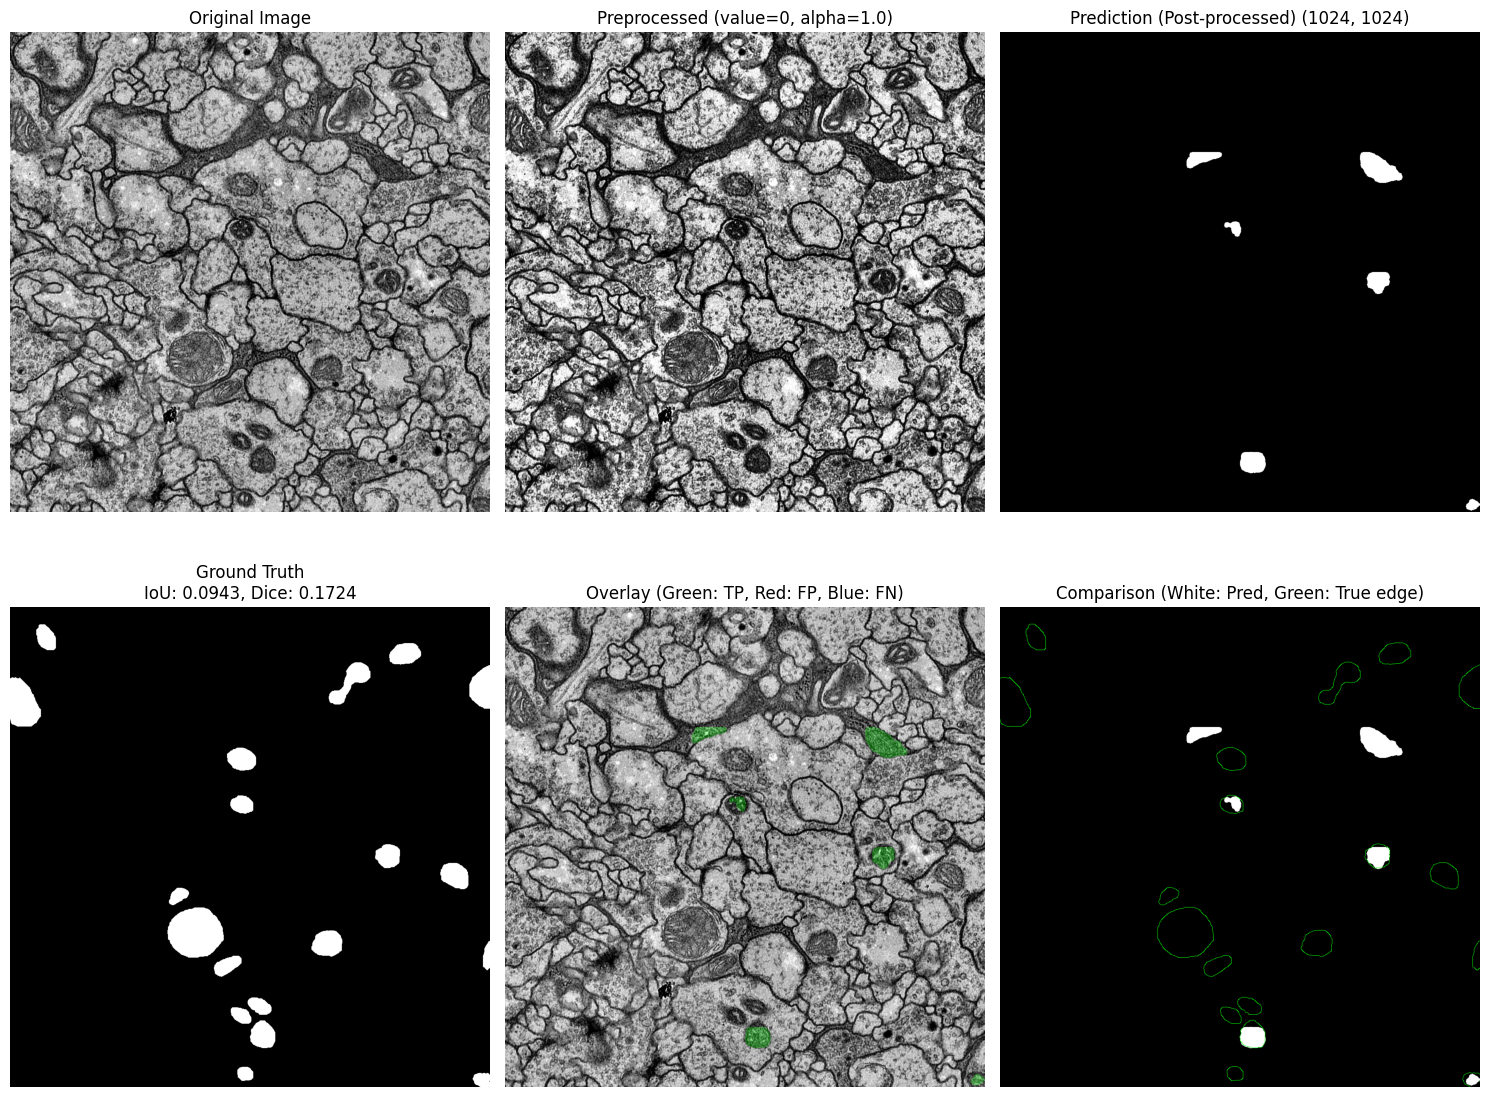

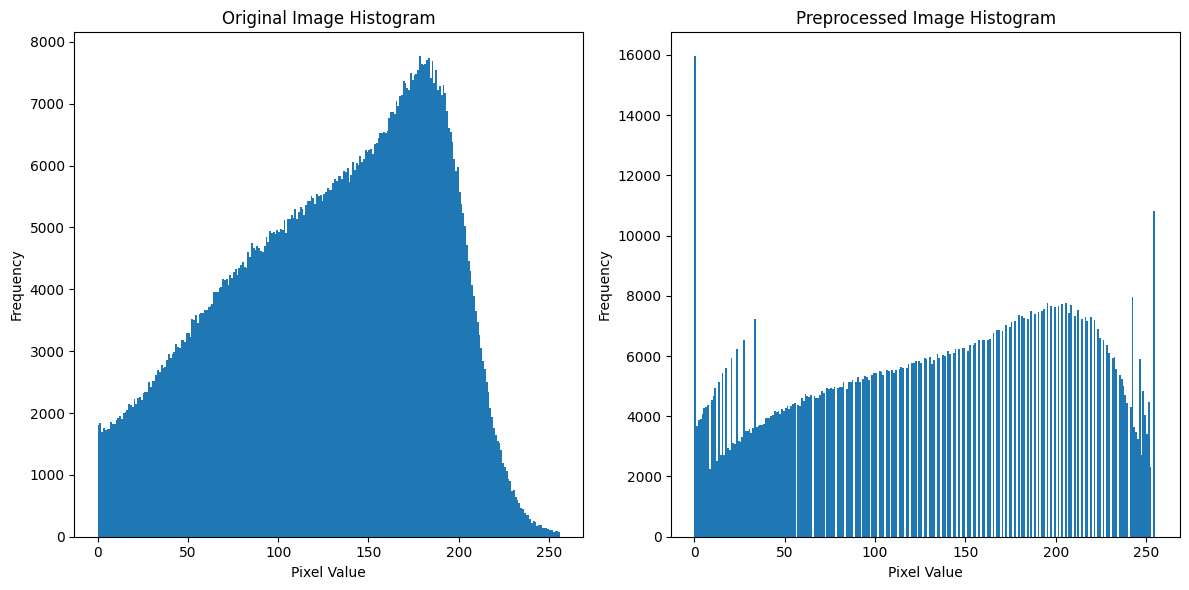

所有结果已保存至 test/predictData 目录
预测完成！
最终指标: IoU=0.0943, Dice=0.1724


In [39]:
def save_prediction_results(model_path, image_path, mask_path=None, save_dir="test/predictData", patch_size=256, 
                            stride=128, value=0, alpha=1.0, device=None):
    """
    加载模型、执行预测并保存结果
    
    参数:
        model_path: 模型文件路径
        image_path: 图像路径
        mask_path: 掩码路径，可选
        save_dir: 保存结果的目录
        patch_size: 处理的patch大小
        stride: patch滑动的步长
        value: 亮度调整值
        alpha: 对比度调整系数
        device: 使用的设备，None则自动选择
    """
    # 设置设备
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 确保保存目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"使用设备: {device}")
    print(f"模型路径: {model_path}")
    print(f"图像路径: {image_path}")
    print(f"掩码路径: {mask_path}")
    print(f"保存目录: {save_dir}")
    print(f"Patch大小: {patch_size}")
    print(f"Stride: {stride}")
    print(f"亮度调整值: {value}")
    print(f"对比度系数: {alpha}")
    
    # 读取原始图像
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 获取文件名（不含扩展名）
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # 使用您的preprocess方法预处理图像
    # 创建一个空白mask作为placeholder，如果没有提供真实mask
    dummy_mask = np.zeros_like(original_img[:,:,0]) if mask_path is None else cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # 初始化预处理器
    preprocessor = ImagePreprocessor()  # 假设您的类名是ImagePreprocessor
    
    # 应用预处理
    preprocessed_img, preprocessed_mask = preprocessor.preprocess(
        original_img, 
        dummy_mask, 
        patch_size=patch_size,
        value=value, 
        alpha=alpha
    )
    
    # 保存预处理后的图像
    if len(preprocessed_img.shape) == 3:
        preprocessed_img_display = preprocessed_img.copy()
    else:
        preprocessed_img_display = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
    
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_preprocessed.png"), preprocessed_img_display)
    
    # 加载模型
    model = load_model(model_path, device)
    
    # 执行预测，显式指定stride参数
    pred_mask = predict(
        model=model,
        image_path=image_path,  # 原始图像路径，predict内部会调用相同的预处理
        mask_path=mask_path,
        device=device,
        save_dir=save_dir,
        patch_size=patch_size,
        stride=stride,  # 确保与训练时一致
        value=value,
        alpha=alpha
    )

    # 保存原始预测掩码（灰度值）
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_raw.png"), (pred_mask * 255).astype(np.uint8))
    
    # 二值化掩码
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_before_postprocess.png"), pred_mask_bin)
    
    # 添加后处理的预测mask
    post_processed_mask = preprocessor.advanced_denoise(
        input_image=pred_mask_bin,    
        min_noise_size=30,       # 小于XX像素的噪点被移除
        max_hole_size=250,       # 小于XX像素的孔洞被填充
        opening_radius=5,        # 开操作结构元半径（控制边缘平滑度）
        closing_radius=3         # 闭操作结构元半径（可选，用于连接断裂区域）
    )
    
    # 保存后处理的预测掩码
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_postprocessed.png"), post_processed_mask)
    
    # 使用后处理的掩码替换原始二值掩码，用于后续所有可视化
    pred_mask_bin = post_processed_mask
    
    # 计算评估指标（如果提供了真实掩码）
    metrics_result = {}
    
    # 真实掩码（如果提供）
    if mask_path and os.path.exists(mask_path):
        # 读取真实掩码
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # 保存二值化的真实掩码
        _, true_mask_bin = cv2.threshold(true_mask, 127, 255, cv2.THRESH_BINARY)
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_true_mask_binary.png"), true_mask_bin)
        
        # 计算IoU和Dice系数，使用后处理的掩码
        # 首先将掩码转换为torch tensor
        pred_tensor = torch.from_numpy((pred_mask_bin > 0).astype(np.float32))  # 使用后处理的掩码
        true_tensor = torch.from_numpy((true_mask_bin > 0).astype(np.float32))
        
        # 确保尺寸一致
        if pred_tensor.shape != true_tensor.shape:
            print(f"警告: 预测掩码 ({pred_tensor.shape}) 和真实掩码 ({true_tensor.shape}) 尺寸不一致")
            # 调整预测掩码大小以匹配真实掩码
            pred_tensor = torch.nn.functional.interpolate(
                pred_tensor.unsqueeze(0).unsqueeze(0), 
                size=true_tensor.shape, 
                mode='nearest'
            ).squeeze(0).squeeze(0)
        
        # 计算评估指标
        iou, dice = calculate_metrics(pred_tensor, true_tensor)
        metrics_result = {"IoU": iou, "Dice": dice}
        
        print(f"IoU: {iou:.4f}")
        print(f"Dice: {dice:.4f}")
        
        # 将指标写入文件
        with open(os.path.join(save_dir, f"{file_name}_metrics.txt"), 'w') as f:
            f.write(f"IoU: {iou:.4f}\n")
            f.write(f"Dice: {dice:.4f}\n")
        
        # 生成对比图
        comparison = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
        
        # 预测掩码为白色（使用后处理的掩码）
        comparison[pred_mask_bin > 0] = [255, 255, 255]  # 白色
        
        # 添加真实掩码的轮廓 (绿色)
        true_mask_edges = cv2.Canny(true_mask_bin, 100, 200)
        comparison[true_mask_edges > 0] = [0, 255, 0]  # 绿色
        
        # 保存对比图
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_comparison.png"), comparison)
        
        # 创建彩色掩码图 (正确:绿色, 错误:红色, 漏检:蓝色)
        color_mask = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
        
        true_mask_bin = true_mask_bin > 0
        pred_mask_bin_bool = pred_mask_bin > 0
        
        # 正确检测 (绿色) - 真实掩码和预测掩码都为1
        color_mask[np.logical_and(true_mask_bin, pred_mask_bin_bool)] = [0, 255, 0]
        
        # 错误检测 (红色) - 真实掩码为0但预测掩码为1
        color_mask[np.logical_and(np.logical_not(true_mask_bin), pred_mask_bin_bool)] = [0, 0, 255]
        
        # 漏检 (蓝色) - 真实掩码为1但预测掩码为0
        color_mask[np.logical_and(true_mask_bin, np.logical_not(pred_mask_bin_bool))] = [255, 0, 0]
        
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_color_mask.png"), color_mask)
        
        # 将彩色掩码叠加到原始图像上
        alpha_overlay = 0.5
        overlay = cv2.addWeighted(original_img, 1, color_mask, alpha_overlay, 0)
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_overlay.png"), overlay)
    
    # 保存预测掩码（不同格式）- 使用后处理的掩码
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_binary.png"), pred_mask_bin)
    
    # 轮廓标记
    orig_with_contours = original_img.copy()
    contours, _ = cv2.findContours(pred_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(orig_with_contours, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_with_contours.png"), orig_with_contours)
    
    # 半透明叠加
    pred_mask_color = cv2.cvtColor(pred_mask_bin, cv2.COLOR_GRAY2BGR)
    pred_mask_color[pred_mask_bin > 0] = [0, 255, 0]  # 将预测区域标记为绿色
    alpha_overlay = 0.3
    overlay = cv2.addWeighted(original_img, 1, pred_mask_color, alpha_overlay, 0)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_overlay.png"), overlay)
    
    # 可视化结果（使用matplotlib）- 添加预处理图像
    plt.figure(figsize=(15, 12))  # 增加画布大小以适应更多的子图
    
    # 原始图像
    plt.subplot(231)
    plt.imshow(original_img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    # 预处理后的图像
    plt.subplot(232)
    if len(preprocessed_img.shape) == 3:
        plt.imshow(cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(preprocessed_img, cmap='gray')
    plt.title(f'Preprocessed (value={value}, alpha={alpha})')
    plt.axis('off')
    
    # 预测掩码（后处理后）
    plt.subplot(233)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title(f'Prediction (Post-processed) {pred_mask_bin.shape}')
    plt.axis('off')
    
    # 真实掩码（如果提供）和指标信息
    if mask_path and os.path.exists(mask_path):
        plt.subplot(234)
        plt.imshow(true_mask, cmap='gray')
        plt.title(f'Ground Truth\nIoU: {metrics_result["IoU"]:.4f}, Dice: {metrics_result["Dice"]:.4f}')
        plt.axis('off')
        
        # 叠加显示（预测掩码轮廓叠加在真实掩码上）
        plt.subplot(235)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title('Overlay (Green: TP, Red: FP, Blue: FN)')
        plt.axis('off')
        
        # 对比图
        plt.subplot(236)
        plt.imshow(cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB))
        plt.title('Comparison (White: Pred, Green: True edge)')
        plt.axis('off')
    else:
        # 如果没有真实掩码，则调整布局
        plt.subplot(234)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title('Prediction Overlay')
        plt.axis('off')
        
        # 预测掩码（二值化）
        plt.subplot(235)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title('Binary Prediction (Post-processed)')
        plt.axis('off')
    
    plt.tight_layout()
    
    # 保存可视化结果
    plt.savefig(os.path.join(save_dir, f"{file_name}_visualization.png"), dpi=300, bbox_inches='tight')
    
    # 显示可视化结果
    plt.show()
    
    # 创建直方图比较
    plt.figure(figsize=(12, 6))
    
    # 原始图像直方图
    if len(original_img.shape) == 3:
        orig_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    else:
        orig_gray = original_img
    
    plt.subplot(121)
    plt.hist(orig_gray.ravel(), 256, [0, 256])
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 预处理后图像直方图
    preproc_gray = preprocessed_img
    if len(preprocessed_img.shape) == 3:
        preproc_gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2GRAY)
    
    plt.subplot(122)
    plt.hist(preproc_gray.ravel(), 256, [0, 256])
    plt.title('Preprocessed Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{file_name}_histograms.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"所有结果已保存至 {save_dir} 目录")
    print("预测完成！")
    
    # 返回后处理后的掩码
    return pred_mask_bin / 255.0, metrics_result if mask_path and os.path.exists(mask_path) else None

# 设置参数
model_path = "models/UnetTrain/PGD_best_model_iou.pth"  # 模型路径

# image_path = "dataset/Lucchi++/Train_In/mask0003.png"  # 测试图片路径
# mask_path = "dataset/Lucchi++/Train_Out/3.png"  # 真实掩码路径（如果有）

# image_path = "dataset/Kasthuri++/Test_In/mask1065.png"  # 测试图片路径
# mask_path = "dataset/Kasthuri++/Test_Out/mask1065.png"  # 真实掩码路径（如果有）

image_path = "dataset/VNC/Test_In/10.tif"  # 测试图片路径
mask_path = "dataset/VNC/Test_Out/10.png"  # 真实掩码路径（如果有）

save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小，建议与训练时一致
stride = 128  # 步长，建议与训练时一致

# 执行预测并保存结果
pred_mask, metrics = save_prediction_results(
    model_path=model_path,
    image_path=image_path,
    mask_path=mask_path,
    save_dir=save_dir,
    patch_size=patch_size,
    stride=stride,  # 明确指定步长
    # 3.9版本的模型因为训练预处理是 -30,1.3 所以这里的预测预处理用0，1会更好(暂时不知道为什么)
    # 3.24版本的模型因为训练预处理是 0,1.0 并且这里用0 1.0好像效果大致20%，虽然特化地调数值会高很多,但是仍然不是泛化效果
    #依然要自定value值和alpha去调参，感觉预处理还是没有做好
    value=0,
    alpha=1.0
)

if metrics:
    print(f"最终指标: IoU={metrics['IoU']:.4f}, Dice={metrics['Dice']:.4f}")

In [4]:
# 3.28修缮save_prediction_result函数，功能细分模块化
    # 可视化模块
def visualize_results(original_img, preprocessed_img, true_mask, pred_mask, metrics, file_name, save_dir, padding_info=None):
    """
    创建和保存可视化结果
    
    参数:
        original_img: 原始图像
        preprocessed_img: 预处理后的图像
        true_mask: 真实掩码
        pred_mask: 预测掩码
        metrics: 评估指标
        file_name: 文件名前缀
        save_dir: 保存目录
        padding_info: 填充信息字典
    """
    # 转换预处理图像为BGR（用于保存）
    if len(preprocessed_img.shape) == 3 and preprocessed_img.shape[2] == 3:
        preprocessed_img_bgr = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2BGR)
    else:
        preprocessed_img_bgr = preprocessed_img
    
    # 创建轮廓图
    orig_with_contours = original_img.copy()
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(orig_with_contours, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_with_contours.png"), orig_with_contours)
    
    # 创建叠加图
    pred_mask_color = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)
    pred_mask_color[pred_mask > 0] = [0, 255, 0]  # 绿色
    alpha_overlay = 0.3
    overlay = cv2.addWeighted(original_img, 1, pred_mask_color, alpha_overlay, 0)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_overlay.png"), overlay)
    
    # 如果有真实掩码，创建对比图
    if true_mask is not None:
        # 创建彩色对比掩码
        color_mask = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
        
        # 调整大小以匹配
        if true_mask.shape != pred_mask.shape:
            resized_pred = cv2.resize(
                pred_mask, 
                (true_mask.shape[1], true_mask.shape[0]), 
                interpolation=cv2.INTER_NEAREST
            )
        else:
            resized_pred = pred_mask
        
        true_mask_bin = true_mask > 0
        pred_mask_bin = resized_pred > 0
        
        # 正确检测 (绿色)
        color_mask[np.logical_and(true_mask_bin, pred_mask_bin)] = [0, 255, 0]
        
        # 错误检测 (红色)
        color_mask[np.logical_and(np.logical_not(true_mask_bin), pred_mask_bin)] = [0, 0, 255]
        
        # 漏检 (蓝色)
        color_mask[np.logical_and(true_mask_bin, np.logical_not(pred_mask_bin))] = [255, 0, 0]
        
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_color_mask.png"), color_mask)
        
        # 叠加到原始图像
        comparison_overlay = cv2.addWeighted(original_img, 1, color_mask, 0.5, 0)
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_comparison.png"), comparison_overlay)
    
    # 创建matplotlib可视化
    plt.figure(figsize=(15, 10))
    
    # 原始图像
    plt.subplot(231)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # 预处理图像（如果有填充信息，显示填充边界）
    plt.subplot(232)
    if len(preprocessed_img.shape) == 3:
        plt.imshow(preprocessed_img)
    else:
        plt.imshow(preprocessed_img, cmap='gray')
    
    # 如果有填充信息，在预处理图像上绘制填充边界
    if padding_info:
        h, w = padding_info["original_size"]
        top, left = padding_info["top"], padding_info["left"]
        
        # 绘制填充边界的矩形
        rect = plt.Rectangle(
            (left, top), 
            w, h, 
            linewidth=2, 
            edgecolor='r', 
            facecolor='none'
        )
        plt.gca().add_patch(rect)
        plt.title(f'Preprocessed Image with Padding\n(red rectangle: original image boundaries)')
    else:
        plt.title('Preprocessed Image')
    plt.axis('off')
    
    # 预测掩码
    plt.subplot(233)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')
    
    # 如果有真实掩码
    if true_mask is not None:
        plt.subplot(234)
        plt.imshow(true_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(235)
        plt.imshow(cv2.cvtColor(comparison_overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Comparison\nIoU: {metrics["IoU"]:.4f}, Dice: {metrics["Dice"]:.4f}')
        plt.axis('off')
    
    plt.subplot(236)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title('Prediction Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{file_name}_visualization.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 创建直方图比较
    plt.figure(figsize=(12, 6))
    
    # 原始图像直方图
    plt.subplot(121)
    if len(original_img.shape) == 3:
        orig_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    else:
        orig_gray = original_img
    plt.hist(orig_gray.ravel(), 256, [0, 256])
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 预处理后图像直方图
    plt.subplot(122)
    if len(preprocessed_img.shape) == 3:
        preproc_gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY)
    else:
        preproc_gray = preprocessed_img
    plt.hist(preproc_gray.ravel(), 256, [0, 256])
    plt.title('Preprocessed Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{file_name}_histograms.png"), dpi=300, bbox_inches='tight')
    plt.close()

def segmentation_pipeline(model_path, image_path, mask_path=None, save_dir="test/predictData", 
                          patch_size=256, stride=None, value=0, alpha=1.0, device=None):
    """
    完整的分割流程：加载模型、预处理、预测、后处理和可视化
    
    参数:
        model_path: 模型文件路径
        image_path: 图像路径
        mask_path: 掩码路径，可选
        save_dir: 保存结果的目录
        patch_size: 处理的patch大小
        stride: patch滑动的步长
        value: 亮度调整值
        alpha: 对比度调整系数
        device: 使用的设备，None则自动选择
    
    返回:
        post_processed_mask: 后处理后的掩码
        metrics: 评估指标（若提供真实掩码）
    """
    # 设置设备
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 设置默认stride
    if stride is None:
        stride = patch_size // 2
    
    # 确保保存目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    # 获取文件名（不含扩展名）作为保存前缀
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    
    print(f"处理图像: {file_name}")
    print(f"使用设备: {device}")
    print(f"模型路径: {model_path}")
    
    # 1. 加载模型
    model = load_model(model_path, device)
    
    # 2. 读取图像和掩码
    # 读取原始图像
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_h, original_w = original_img.shape[:2]
    
    # 读取真实掩码（如果有）
    true_mask = None
    if mask_path and os.path.exists(mask_path):
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # 保存引用到原始真实掩码，用于最终评估
        original_true_mask = true_mask.copy()
    
    # 保存原始图像
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_original.png"), original_img)
    
    # 如果有真实掩码，保存它
    if true_mask is not None:
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_true_mask.png"), true_mask)
    
    # 3. 预处理
    # 确保图像尺寸能被patch_size整除，必要时进行填充
    # 计算需要填充的尺寸
    # 先计算padding_info
    padding_info = ImagePreprocessor.calculate_padding_info(original_h, original_w, patch_size)

    # 从padding_info中提取填充值
    top_pad = padding_info["top"]
    bottom_pad = padding_info["bottom"]
    left_pad = padding_info["left"]
    right_pad = padding_info["right"]
    
    
    # 初始化预处理器
    preprocessor = ImagePreprocessor()
    
    # 应用预处理（包含亮度对比度调整和填充）
    preprocessed_img, preprocessed_mask = preprocessor.preprocess(
        original_img_rgb, 
        true_mask, 
        patch_size=patch_size,
        padding=(top_pad, bottom_pad, left_pad, right_pad),  # 传入填充信息
        value=value, 
        alpha=alpha
    )
    
    # 保存预处理后的图像
    preprocessed_img_bgr = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_preprocessed.png"), preprocessed_img_bgr)
    
    # 如果有预处理后的掩码，保存它
    if preprocessed_mask is not None:
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_preprocessed_mask.png"), 
                   (preprocessed_mask ).astype(np.uint8))
    
    # 输出预处理前后的尺寸变化
    print(f"原始图像尺寸: {original_h}x{original_w}")
    print(f"预处理后图像尺寸: {preprocessed_img.shape[0]}x{preprocessed_img.shape[1]}")
    print(f"填充信息: 上={top_pad}, 下={bottom_pad}, 左={left_pad}, 右={right_pad}")
    
    # 4. 执行模型预测
    pred_mask, raw_metrics = predict(
        model=model,
        image=preprocessed_img,
        mask=preprocessed_mask,
        device=device,
        patch_size=patch_size,
        stride=stride
    )
    
    # 保存原始预测结果
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_raw.png"), 
               (pred_mask * 255).astype(np.uint8))
    
    # 5. 裁剪回原始尺寸
    # 计算裁剪区域
    h_start = top_pad
    w_start = left_pad
    h_end = preprocessed_img.shape[0] - bottom_pad
    w_end = preprocessed_img.shape[1] - right_pad
    
    # 确保不会越界
    h_start = max(0, h_start)
    w_start = max(0, w_start)
    h_end = min(preprocessed_img.shape[0], h_end)
    w_end = min(preprocessed_img.shape[1], w_end)
    
    # 裁剪预测掩码回原始尺寸
    pred_mask_original_size = pred_mask[h_start:h_end, w_start:w_end]
    
    # 确保预测掩码与原始图像尺寸完全匹配
    if pred_mask_original_size.shape[:2] != (original_h, original_w):
        print(f"警告: 裁剪后的预测掩码 ({pred_mask_original_size.shape[:2]}) 与原始图像 ({original_h}, {original_w}) 尺寸不完全匹配，正在调整...")
        pred_mask_original_size = cv2.resize(
            pred_mask_original_size, 
            (original_w, original_h), 
            interpolation=cv2.INTER_NEAREST
        )
    
    # 保存裁剪后的预测结果
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_original_size.png"), 
               (pred_mask_original_size * 255).astype(np.uint8))
    
    # 6. 后处理:降噪
    post_processed_mask = ImagePreprocessor.advanced_denoise(
        input_image=pred_mask_original_size,  # 已经是0-1范围的浮点数
        binary_threshold=0.5,
        min_noise_size=30,
        max_hole_size=200,
        opening_radius=5,
        closing_radius=3
    )

    # 保存后处理的掩码（转换为0-255范围保存图像）
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_final.png"), 
            (post_processed_mask * 255).astype(np.uint8))
    
    # 7. 计算后处理后的评估指标
    final_metrics = None
    if true_mask is not None:
        # 确保掩码尺寸完全匹配
        if post_processed_mask.shape != original_true_mask.shape:
            print(f"警告: 后处理掩码 ({post_processed_mask.shape}) 与原始真实掩码 ({original_true_mask.shape}) 尺寸不一致，正在调整...")
            # 调整大小以匹配原始真实掩码
            post_processed_mask_resized = cv2.resize(
                post_processed_mask, 
                (original_true_mask.shape[1], original_true_mask.shape[0]), 
                interpolation=cv2.INTER_NEAREST
            )
        else:
            post_processed_mask_resized = post_processed_mask
        
        # 转换掩码格式为浮点型 (同predict函数中的处理方式)
        if original_true_mask.dtype != np.float32:
            if original_true_mask.dtype == np.uint8:
                # 关键修改：使用"== 255"而不是"> 0"进行二值化
                true_mask_float = (original_true_mask == 255).astype(np.float32)
            else:
                true_mask_float = original_true_mask.astype(np.float32)
        else:
            true_mask_float = original_true_mask
        
        # 将后处理掩码转换为浮点型
        post_processed_float = (post_processed_mask_resized > 0).astype(np.float32)
        
        # 转换为tensor计算IoU和Dice (与predict函数相同)
        pred_tensor = torch.from_numpy(post_processed_float)
        true_tensor = torch.from_numpy((true_mask_float > 0.5).astype(np.float32))
        
        # 计算评估指标
        iou, dice = calculate_metrics(pred_tensor, true_tensor)
        final_metrics = {"IoU": iou, "Dice": dice}
        
        # 将指标写入文件
        with open(os.path.join(save_dir, f"{file_name}_metrics.txt"), 'w') as f:
            if raw_metrics:
                f.write(f"原始预测: IoU={raw_metrics['IoU']:.4f}, Dice={raw_metrics['Dice']:.4f}\n")
            f.write(f"后处理后: IoU={iou:.4f}, Dice={dice:.4f}\n")
        
        # 打印原始和后处理的评估指标比较
        if raw_metrics:
            print(f"原始预测指标: IoU={raw_metrics['IoU']:.4f}, Dice={raw_metrics['Dice']:.4f}")
        print(f"后处理后指标: IoU={iou:.4f}, Dice={dice:.4f}")
        
        # 计算改善百分比
        if raw_metrics:
            iou_improvement = (iou - raw_metrics['IoU']) / raw_metrics['IoU'] * 100 if raw_metrics['IoU'] > 0 else float('inf')
            dice_improvement = (dice - raw_metrics['Dice']) / raw_metrics['Dice'] * 100 if raw_metrics['Dice'] > 0 else float('inf')
            print(f"指标改善: IoU: {iou_improvement:.2f}%, Dice: {dice_improvement:.2f}%")
            
    # 8. 创建可视化结果
    visualize_results(
        original_img=original_img,
        preprocessed_img=preprocessed_img,
        true_mask=original_true_mask if true_mask is not None else None,
        pred_mask=post_processed_mask,
        metrics=final_metrics,
        file_name=file_name,
        save_dir=save_dir,
        padding_info=padding_info
    )
    
    return post_processed_mask / 255.0, final_metrics



In [8]:
## 3.28最新的predict全流程设置
# 设置参数
model_path = "models/UnetTrain/PGD_best_model_iou.pth"  # 模型路径

# image_path = "dataset/Lucchi++/Train_In/mask0003.png"  # 测试图片路径
# mask_path = "dataset/Lucchi++/Train_Out/3.png"  # 真实掩码路径（如果有）

image_path = "dataset/Kasthuri++/Test_In/mask1065.png"  # 测试图片路径
mask_path = "dataset/Kasthuri++/Test_Out/mask1065.png"  # 真实掩码路径（如果有）


# image_path = "dataset/VNC/Test_In/10.tif"  # 测试图片路径
# mask_path = "dataset/VNC/Test_Out/10.png"  # 真实掩码路径（如果有）

save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小
stride = 128  # 步长

# 执行分割流程
pred_mask, metrics = segmentation_pipeline(
    model_path=model_path,
    image_path=image_path,
    mask_path=mask_path,
    save_dir=save_dir,
    patch_size=patch_size,
    stride=stride,
    value=0,
    alpha=1.0
)

if metrics:
    print(f"最终评估指标: IoU={metrics['IoU']:.4f}, Dice={metrics['Dice']:.4f}")

处理图像: mask1065
使用设备: cuda
模型路径: models/UnetTrain/PGD_best_model_iou.pth
模型已从 models/UnetTrain/PGD_best_model_iou.pth 加载
<class 'numpy.ndarray'>
原始图像尺寸: 1553x1334
预处理后图像尺寸: 1792x1536
填充信息: 上=119, 下=120, 左=101, 右=101
评估指标: IoU=0.8166, Dice=0.8990
原始预测指标: IoU=0.8166, Dice=0.8990
后处理后指标: IoU=0.8134, Dice=0.8971
指标改善: IoU: -0.40%, Dice: -0.22%
最终评估指标: IoU=0.8134, Dice=0.8971


##### 3.26日更新：形态学消除噪声测试,预计加入一个面积判断，即白点面积小于一定则直接消除，先用一次形态学初步处理再进行面积判断，避免一些潜在特征被消除。
 

图像加载成功，尺寸: (1553, 1334, 3)
去噪后图像已保存至: E:/GitHubDesktopPath/sam2/test/predictData/mask1065_prediction_denoised_done.png


C:\Users\leo\AppData\Local\Temp\ipykernel_22028\1316516394.py:48: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\1316516394.py:48: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\1316516394.py:48: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\1316516394.py:48: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\1316516394.py:48: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\1316516394.py:48: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from cur

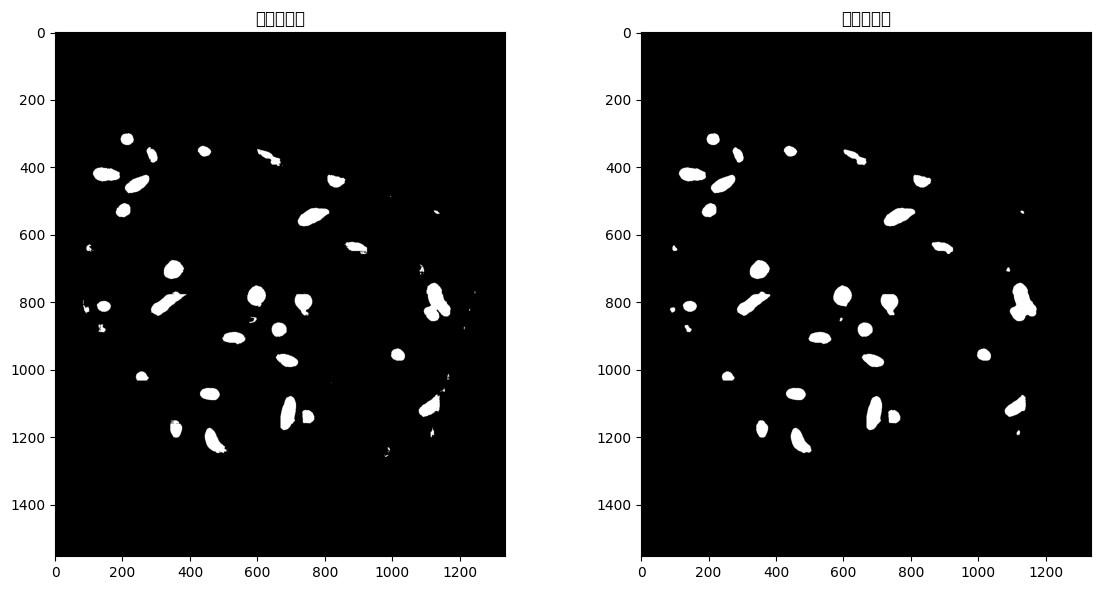

In [ ]:
from functions.imagePreprocessing import ImagePreprocessor


p = ImagePreprocessor()

# 正确定义路径（没有逗号）
input_path = "E:/GitHubDesktopPath/sam2/test/predictData/mask1065_prediction_original_size.png"
output_path = "E:/GitHubDesktopPath/sam2/test/predictData/mask1065_prediction_denoised_done.png"

# 读取输入图像
input_img = cv2.imread(input_path)

# 检查图像是否成功加载
if input_img is None:
    print(f"错误: 无法读取图像文件: {input_path}")
else:
    print("图像加载成功，尺寸:", input_img.shape)
    
    # 应用高级去噪
    denoised_image = p.advanced_denoise(
        input_img,
        # binary_threshold=128,    # 根据图像调整
        min_noise_size=30,       # 小于XX像素的噪点被移除
        max_hole_size=200,       # 小于XX像素的孔洞被填充
        opening_radius=3,        # 开操作结构元半径（控制边缘平滑度）
        closing_radius=7,        # 闭操作结构元半径（可选，用于连接断裂区域）
        # invert_input=False,     # 是否反转输入图像（黑/白反转）
        # invert_output=False     # 是否反转输出图像
    )
    
    # 保存结果
    cv2.imwrite(output_path, denoised_image)
    print(f"去噪后图像已保存至: {output_path}")
    
    # 正确显示图像
    plt.figure(figsize=(12, 6))
    
    # 显示原始图像
    plt.subplot(1, 2, 1)
    plt.title("去噪前图像")
    plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
    
    # 显示去噪后图像
    plt.subplot(1, 2, 2)
    plt.title("去噪后图像")
    plt.imshow(denoised_image, cmap='gray')
    
    plt.tight_layout()
    plt.show() 
     

3.27 计划： 新增对每个预处理的patch添加随机性的图形变化，比如
    旋转(四面旋转变化和镜像翻转 or对大图进行随机旋转然后patch分割)
    明暗度和对比度在一个区域内的随机浮动
    ！！需要添加图片的转换接口，比如从RGB转灰度图，或者从灰度图转RGB图之类的，因为web上调用会起冲突，全程尽量保持在一个相对的图片格式上，目前已知的是  路径、PIL(不确定)、cv2的图片格式有点多样，去看看能不能统一在3类内的接口转化。
    
前提：需要对预处理和data.py的预处理方式从整张图片修改成对patch进行操作，对应的mask如有必要也要修改。


##### 尝试对imagePreprocessor.py内的advance_denoise()函数进行修改，使其支持输出的图像格式自选

 



    需要说明： 
        图像格式有三种--- gray  bgr  rgb，
    
    
    gray是单通道灰度图:
        数据结构：2维NumPy数组
        维度：(height, width)
        数据类型：np.uint8
        值范围：0-255
        特点：单通道，每个像素只有一个值表示亮度

    BGR是 openCV标准的彩色图
        code: cv2.COLOR_GRAY2BGR  # 转为BGR(OpenCV标准)
        数据结构：3维NumPy数组
        维度：(height, width, 3)
        数据类型：np.uint8
        通道顺序：[蓝色, 绿色, 红色]
        特点：这是OpenCV默认的彩色图像格式

    RGB是3通道彩色图:
        code: cv2.COLOR_BGR2RGB  # 转为RGB(Web标准)
        数据结构：3维NumPy数组
        维度：(height, width, 3)
        数据类型：np.uint8
        通道顺序：[红色, 绿色, 蓝色]
        特点：这是Web和大多数图像库使用的标准彩色图像格式

三种格式都是NumPy数组      
Web前端通常使用RGB格式，而OpenCV内部操作默认使用BGR格式。
(这些内容有待验证！！，需要和对应的图像处理库进行交流确保格式正确再迁移去使用)
 


In [2]:
from skimage import morphology
def advanced_denoise(
        input_image,                    # 输入图像变量
        binary_threshold=128,           # 二值化阈值（0-255）
        min_noise_size=50,              # 最小噪声面积（小于此值的白色区域会被移除）
        max_hole_size=100,              # 最大孔洞面积（小于此值的黑色孔洞会被填充）
        opening_radius=2,               # 开操作结构元半径（控制边缘平滑度）
        closing_radius=None,            # 闭操作结构元半径（可选，用于连接断裂区域）
        invert_input=False,             # 是否反转输入图像（黑/白反转）
        invert_output=False,            # 是否反转输出图像
        output_format='bgr'             # 输出格式：'gray', 'bgr'或'rgb'
    ):
        """
        高级形态学去噪函数（基于连通域分析）
        
        参数说明：
        1. input_image: 输入图像变量（灰度或彩色图像）
        2. binary_threshold: 二值化阈值（高于此值为白色，低于为黑色）
        3. min_noise_size: 最小噪声面积（像素数），小于此值的孤立白点会被移除
        4. max_hole_size: 最大孔洞面积（像素数），小于此值的黑色孔洞会被填充
        5. opening_radius: 开操作结构元的圆盘半径（消除毛刺）
        6. closing_radius: 闭操作结构元的圆盘半径（可选，连接断裂区域）
        7. invert_input: 输入图像是否黑白反转（True表示黑底白字）
        8. invert_output: 输出图像是否黑白反转
        9. output_format: 输出图像格式，可选'gray'(灰度), 'bgr'(OpenCV格式)或'rgb'(Web友好)
        
        返回：
        处理后的图像，格式根据output_format参数决定
        """
        # 确保输入图像为灰度图
        if len(input_image.shape) > 2:
            img = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
        else:
            img = input_image.copy()
        
        # 二值化
        _, binary = cv2.threshold(img, binary_threshold, 255, cv2.THRESH_BINARY)
        
        # 可选：反转图像（例如黑底白字的情况）
        if invert_input:
            binary = 255 - binary
        
        # 转换为布尔矩阵（True=白色，False=黑色）
        binary_bool = binary.astype(bool)
        
        # 第二步：填充小孔洞（黑色噪点）
        cleaned = morphology.remove_small_holes(binary_bool, area_threshold=max_hole_size)
        
        # 第一步：移除小面积噪声（白色噪点）
        filled = morphology.remove_small_objects(cleaned, min_size=min_noise_size)
        
        # 第三步：开操作（平滑边缘）
        if opening_radius > 0:
            smoothed = morphology.opening(filled, morphology.disk(opening_radius))
        else:
            smoothed = filled
        
        # 可选：闭操作（连接断裂区域）
        if closing_radius and closing_radius > 0:
            smoothed = morphology.closing(smoothed, morphology.disk(closing_radius))
        
        # 恢复为0-255图像
        result = smoothed.astype(np.uint8) * 255
        
        # 可选：反转输出
        if invert_output:
            result = 255 - result
        
        # 根据需要的输出格式转换
        if output_format.lower() == 'gray':
            return result  # 直接返回灰度图
        elif output_format.lower() == 'bgr':
            return cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)  # 转为BGR(OpenCV标准)
        elif output_format.lower() == 'rgb':
            bgr = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
            return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)  # 转为RGB(Web标准)
        else:
            # 默认返回BGR格式
            return cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

##### 对random preprocessing的初步测试，未完成

In [ ]:

def apply_augmentations(self, image, mask):
    """应用数据增强以提高模型泛化能力"""
    # 随机亮度和对比度变化
    brightness = random.uniform(-30, 30)
    contrast = random.uniform(0.7, 1.3)
    image = self.adjust_brightness(image, brightness, mask)
    image = self.adjust_contrast(image, contrast, mask)
    
    # 随机旋转
    angle = random.uniform(-10, 10)
    height, width = image.shape[:2]
    center = (width/2, height/2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (width, height), 
                          borderMode=cv2.BORDER_CONSTANT, 
                          borderValue=0)
    
    # 随机高斯噪声
    if random.random() > 0.5:
        row, col, ch = image.shape
        mean = 0
        sigma = random.uniform(1, 5)
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        image = np.clip(noisy, 0, 255).astype(np.uint8)
    
    return image



##### 分析图片或者文件夹中的图片详细信息代码

下面是创建了分析图象信息的func函数集合，可以搜索单一图片或者文件夹，用于查看图片的通道颜色等详细信息

In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

def analyze_image(image_path, save_analysis=True, show_images=True, output_dir=None):
    """
    分析图像文件并输出详细信息
    
    参数:
        image_path: 图像文件路径
        save_analysis: 是否保存分析结果和可视化图像
        show_images: 是否显示图像
        output_dir: 保存分析结果的目录，默认为当前目录下的'image_analysis'
    
    返回:
        包含分析结果的字典
    """
    # 如果输出目录未指定，则使用默认目录
    if save_analysis and output_dir is None:
        output_dir = os.path.join(os.path.dirname(image_path), 'image_analysis')
    
    if save_analysis:
        os.makedirs(output_dir, exist_ok=True)
    
    # 获取文件基本信息
    file_name = os.path.basename(image_path)
    file_ext = os.path.splitext(file_name)[1].lower()
    file_size = os.path.getsize(image_path) / 1024  # KB
    
    # 读取图像
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print(f"无法读取图像: {image_path}")
        return {"error": "无法读取图像"}
    
    # 确定图像类型和通道数
    if len(image.shape) == 2:
        channels = 1
        color_type = "灰度图"
    elif len(image.shape) == 3:
        channels = image.shape[2]
        if channels == 3:
            color_type = "RGB/BGR图"
        elif channels == 4:
            color_type = "RGBA/BGRA图 (带透明通道)"
        else:
            color_type = f"多通道图像 ({channels}通道)"
    else:
        color_type = "未知类型"
    
    # 图像尺寸
    height, width = image.shape[:2]
    
    # 图像数据类型和值范围
    dtype = str(image.dtype)
    min_val = np.min(image)
    max_val = np.max(image)
    
    # 唯一值分析
    unique_values = np.unique(image)
    num_unique = len(unique_values)
    
    # 对于灰度或单通道图像，分析更详细的特性
    if channels == 1:
        # 如果唯一值数量少于10，详细分析分布
        if num_unique < 10:
            value_counts = {}
            for value in unique_values:
                count = np.sum(image == value)
                percentage = count / (height * width) * 100
                value_counts[int(value)] = (int(count), round(percentage, 2))
            
            # 判断是否是二值图像
            if num_unique == 2:
                is_binary = True
                binary_values = list(unique_values)
                foreground_value = max(binary_values)
                background_value = min(binary_values)
                
                # 计算前景像素百分比
                foreground_pixels = np.sum(image == foreground_value)
                foreground_percentage = foreground_pixels / (height * width) * 100
            else:
                is_binary = False
                foreground_value = None
                background_value = None
                foreground_percentage = None
        else:
            # 为大量唯一值计算直方图
            hist = cv2.calcHist([image], [0], None, [256], [0, 256])
            value_counts = "太多值无法详细列出"
            is_binary = False
            foreground_value = None
            background_value = None
            foreground_percentage = None
            
        # 如果是二值图像或接近二值图像，尝试提取连通区域信息
        if is_binary or num_unique < 5:
            # 使用最大值作为前景
            if is_binary:
                binary_img = (image == foreground_value).astype(np.uint8) * 255
            else:
                # 如果不是严格二值图像，使用Otsu阈值化
                _, binary_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # 查找连通区域
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
            
            # 排除背景组件
            num_regions = num_labels - 1
            
            # 如果组件数量不超过20个，计算每个组件的大小
            if 1 <= num_regions <= 20:
                region_sizes = []
                for i in range(1, num_labels):  # 跳过背景（标签0）
                    size = stats[i, cv2.CC_STAT_AREA]
                    percentage = size / (height * width) * 100
                    region_sizes.append((size, percentage))
                
                # 按大小排序
                region_sizes.sort(reverse=True)
            else:
                region_sizes = f"检测到{num_regions}个连通区域，数量过多无法详细列出"
        else:
            binary_img = None
            num_regions = None
            region_sizes = None
    else:
        # 彩色图像的情况
        # 分析每个通道
        channel_info = []
        for i in range(channels):
            channel = image[:, :, i]
            ch_min = np.min(channel)
            ch_max = np.max(channel)
            ch_mean = np.mean(channel)
            ch_std = np.std(channel)
            channel_info.append({
                "min": ch_min,
                "max": ch_max,
                "mean": ch_mean,
                "std": ch_std
            })
        
        # 彩色图像中不计算二值图像特性
        is_binary = False
        binary_img = None
        value_counts = None
        foreground_value = None
        background_value = None
        foreground_percentage = None
        num_regions = None
        region_sizes = None
    
    # 创建结果字典
    result = {
        "文件信息": {
            "文件名": file_name,
            "文件扩展名": file_ext,
            "文件大小": f"{file_size:.2f} KB"
        },
        "图像基本信息": {
            "尺寸": f"{width}x{height}",
            "类型": color_type,
            "通道数": channels,
            "数据类型": dtype,
            "值范围": f"[{min_val}, {max_val}]",
            "唯一值数量": num_unique,
            "唯一值": unique_values.tolist() if num_unique < 30 else f"太多值({num_unique})无法列出"
        }
    }
    
    # 添加单通道/灰度图特定信息
    if channels == 1:
        binary_info = {
            "是否为二值图像": is_binary,
        }
        
        if is_binary:
            binary_info.update({
                "二值": f"背景={background_value}, 前景={foreground_value}",
                "前景像素比例": f"{foreground_percentage:.2f}%"
            })
        
        if value_counts is not None and isinstance(value_counts, dict):
            binary_info["像素值分布"] = {f"值 {k}": f"{v[0]} 像素 ({v[1]}%)" for k, v in value_counts.items()}
        
        if num_regions is not None:
            binary_info["连通区域数量"] = num_regions
        
        if region_sizes is not None and isinstance(region_sizes, list):
            binary_info["连通区域大小"] = [f"区域 {i+1}: {size} 像素 ({percentage:.2f}%)" 
                                 for i, (size, percentage) in enumerate(region_sizes)]
        
        result["二值图像分析"] = binary_info
    
    # 添加彩色图像特定信息
    if channels > 1:
        channel_names = ["蓝", "绿", "红", "Alpha"] if channels <= 4 else [f"通道 {i}" for i in range(channels)]
        result["通道分析"] = {
            channel_names[i]: {
                "最小值": info["min"],
                "最大值": info["max"],
                "平均值": f"{info['mean']:.2f}",
                "标准差": f"{info['std']:.2f}"
            } for i, info in enumerate(channel_info)
        }
    
    # 打印分析结果
    print("\n=== 图像分析结果 ===")
    for section, items in result.items():
        print(f"\n{section}:")
        if isinstance(items, dict):
            for key, value in items.items():
                if isinstance(value, dict):
                    print(f"  {key}:")
                    for k, v in value.items():
                        print(f"    {k}: {v}")
                else:
                    print(f"  {key}: {value}")
        else:
            print(f"  {items}")
    
    # 可视化和保存分析结果
    if show_images or save_analysis:
        plt.figure(figsize=(12, 10))
        
        # 设置子图数量
        if channels == 1:
            if is_binary or binary_img is not None:
                num_plots = 3
            else:
                num_plots = 2
        else:
            num_plots = channels + 1
        
        # 显示原始图像
        plt.subplot(num_plots, 1, 1)
        if channels == 1:
            plt.imshow(image, cmap='gray')
        else:
            # 转换BGR到RGB
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
        plt.title("原始图像")
        plt.axis('off')
        
        # 对于灰度图，显示直方图
        if channels == 1:
            plt.subplot(num_plots, 1, 2)
            plt.hist(image.ravel(), bins=256, range=[0, 256], color='gray')
            plt.title("像素值分布")
            plt.xlabel("像素值")
            plt.ylabel("频率")
            
            # 如果是二值图像，显示二值图
            if is_binary or binary_img is not None:
                plt.subplot(num_plots, 1, 3)
                plt.imshow(binary_img, cmap='gray')
                plt.title("二值图像")
                plt.axis('off')
        else:
            # 显示各通道图像
            for i in range(channels):
                plt.subplot(num_plots, 1, i + 2)
                plt.imshow(image[:, :, i], cmap='gray')
                plt.title(f"通道 {i+1}")
                plt.axis('off')
        
        plt.tight_layout()
        
        if save_analysis:
            analysis_img_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_analysis.png")
            plt.savefig(analysis_img_path)
            print(f"\n分析图像已保存: {analysis_img_path}")
            
            # 保存分析文本
            analysis_txt_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_analysis.txt")
            with open(analysis_txt_path, 'w', encoding='utf-8') as f:
                f.write("=== 图像分析结果 ===\n\n")
                for section, items in result.items():
                    f.write(f"{section}:\n")
                    if isinstance(items, dict):
                        for key, value in items.items():
                            if isinstance(value, dict):
                                f.write(f"  {key}:\n")
                                for k, v in value.items():
                                    f.write(f"    {k}: {v}\n")
                            else:
                                f.write(f"  {key}: {value}\n")
                    else:
                        f.write(f"  {items}\n")
                    f.write("\n")
            print(f"分析文本已保存: {analysis_txt_path}")
        
        if show_images:
            plt.show()
        else:
            plt.close()
    
    return result

def analyze_images_in_folder(folder_path, pattern="*.*", recursive=False, **kwargs):
    """
    分析文件夹中的所有图像
    
    参数:
        folder_path: 文件夹路径
        pattern: 文件匹配模式，如"*.png"
        recursive: 是否递归搜索子文件夹
        **kwargs: 传递给analyze_image的其他参数
    """
    folder_path = Path(folder_path)
    if recursive:
        image_paths = list(folder_path.glob(f"**/{pattern}"))
    else:
        image_paths = list(folder_path.glob(pattern))
    
    # 过滤可能的图像文件
    valid_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.webp']
    image_paths = [str(p) for p in image_paths if p.suffix.lower() in valid_extensions]
    
    if not image_paths:
        print(f"在 {folder_path} 中没有找到图像文件")
        return
    
    print(f"找到 {len(image_paths)} 个图像文件")
    
    for image_path in image_paths:
        print(f"\n分析图像: {image_path}")
        analyze_image(image_path, **kwargs)


=== 图像分析结果 ===

文件信息:
  文件名: mask1065_prediction_denoised_done.png
  文件扩展名: .png
  文件大小: 10.92 KB

图像基本信息:
  尺寸: 1334x1553
  类型: 灰度图
  通道数: 1
  数据类型: uint8
  值范围: [0, 255]
  唯一值数量: 2
  唯一值: [0, 255]

二值图像分析:
  是否为二值图像: True
  二值: 背景=0, 前景=255
  前景像素比例: 2.62%
  像素值分布:
    值 0: 2017476 像素 (97.38%)
    值 255: 54226 像素 (2.62%)
  连通区域数量: 34


C:\Users\leo\AppData\Local\Temp\ipykernel_22028\3635058310.py:272: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\3635058310.py:272: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\3635058310.py:272: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\3635058310.py:272: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\3635058310.py:272: UserWarning: Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_22028\3635058310.py:272: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing fr

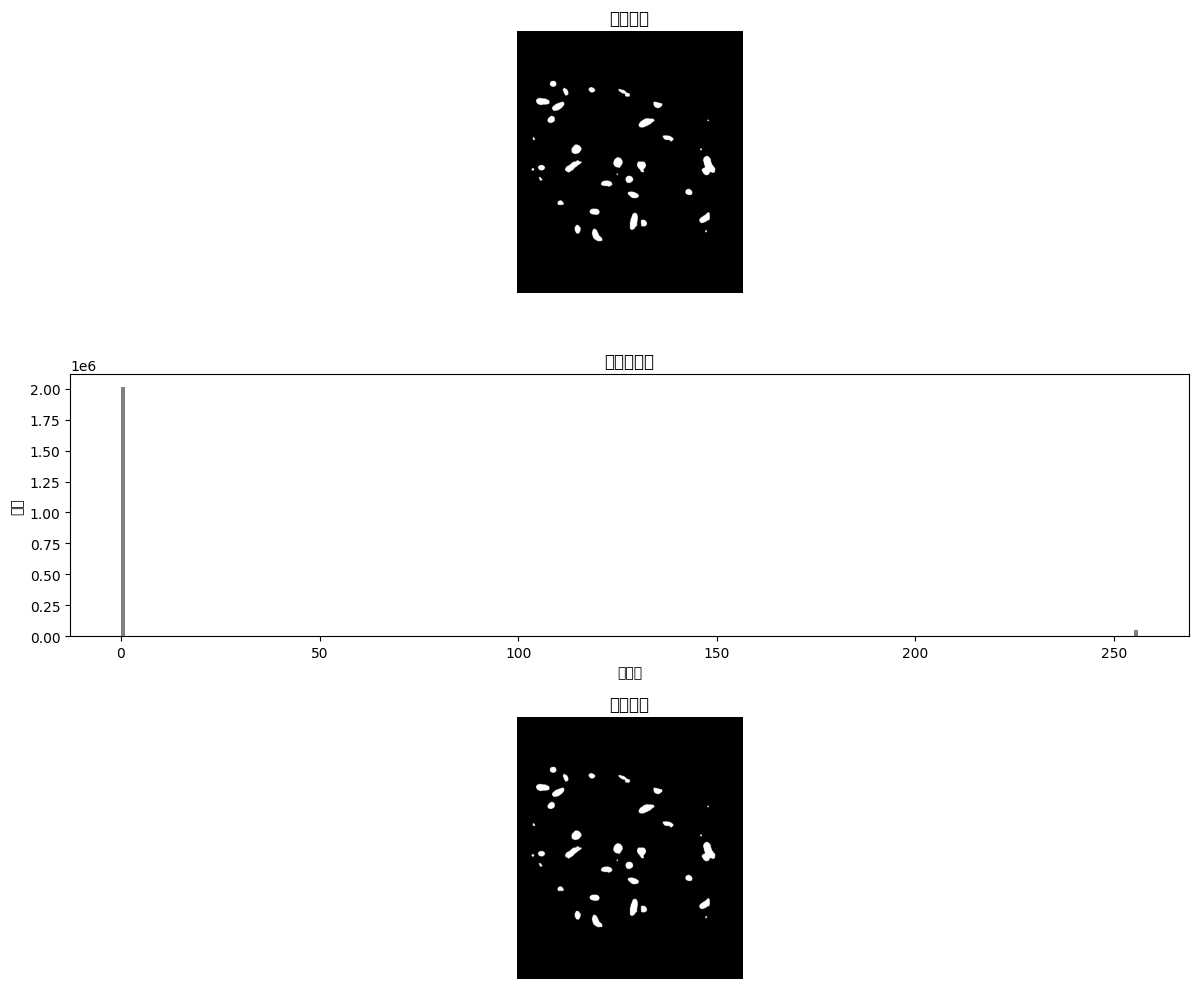

{'文件信息': {'文件名': 'mask1065_prediction_denoised_done.png',
  '文件扩展名': '.png',
  '文件大小': '10.92 KB'},
 '图像基本信息': {'尺寸': '1334x1553',
  '类型': '灰度图',
  '通道数': 1,
  '数据类型': 'uint8',
  '值范围': '[0, 255]',
  '唯一值数量': 2,
  '唯一值': [0, 255]},
 '二值图像分析': {'是否为二值图像': True,
  '二值': '背景=0, 前景=255',
  '前景像素比例': '2.62%',
  '像素值分布': {'值 0': '2017476 像素 (97.38%)', '值 255': '54226 像素 (2.62%)'},
  '连通区域数量': 34}}

In [11]:
# 分析单个图像并显示结果
image_path = "E:/GitHubDesktopPath/sam2/test/predictData/mask1065_prediction_denoised_done.png"  # 测试图片路径

analyze_image(image_path, save_analysis=False, show_images=True)

# # 分析文件夹中的所有PNG图像
# folder_path = "path/to/your/folder"
# analyze_images_in_folder(folder_path, pattern="*.png", save_analysis=True, show_images=False)

##### 分析mask的0 2 255三个数值的分布情况，尝试找出mask问题


分析图像: dataset/Kasthuri++/Test_In/mask1065.png
对应掩码: dataset/Kasthuri++/Test_Out/mask1065.png
掩码中的唯一值: [  0   2 255]


C:\Users\leo\AppData\Local\Temp\ipykernel_28940\1928711682.py:111: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_28940\1928711682.py:111: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_28940\1928711682.py:111: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_28940\1928711682.py:111: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_28940\1928711682.py:111: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_28940\1928711682.py:111: UserWarning: Glyph 26223 (\N{CJK UNIFIED IDEOGRAPH-666F}) missing fr

可视化结果已保存至: analysis_output\mask1065_mask_analysis.png


C:\Users\leo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32972 (\N{CJK

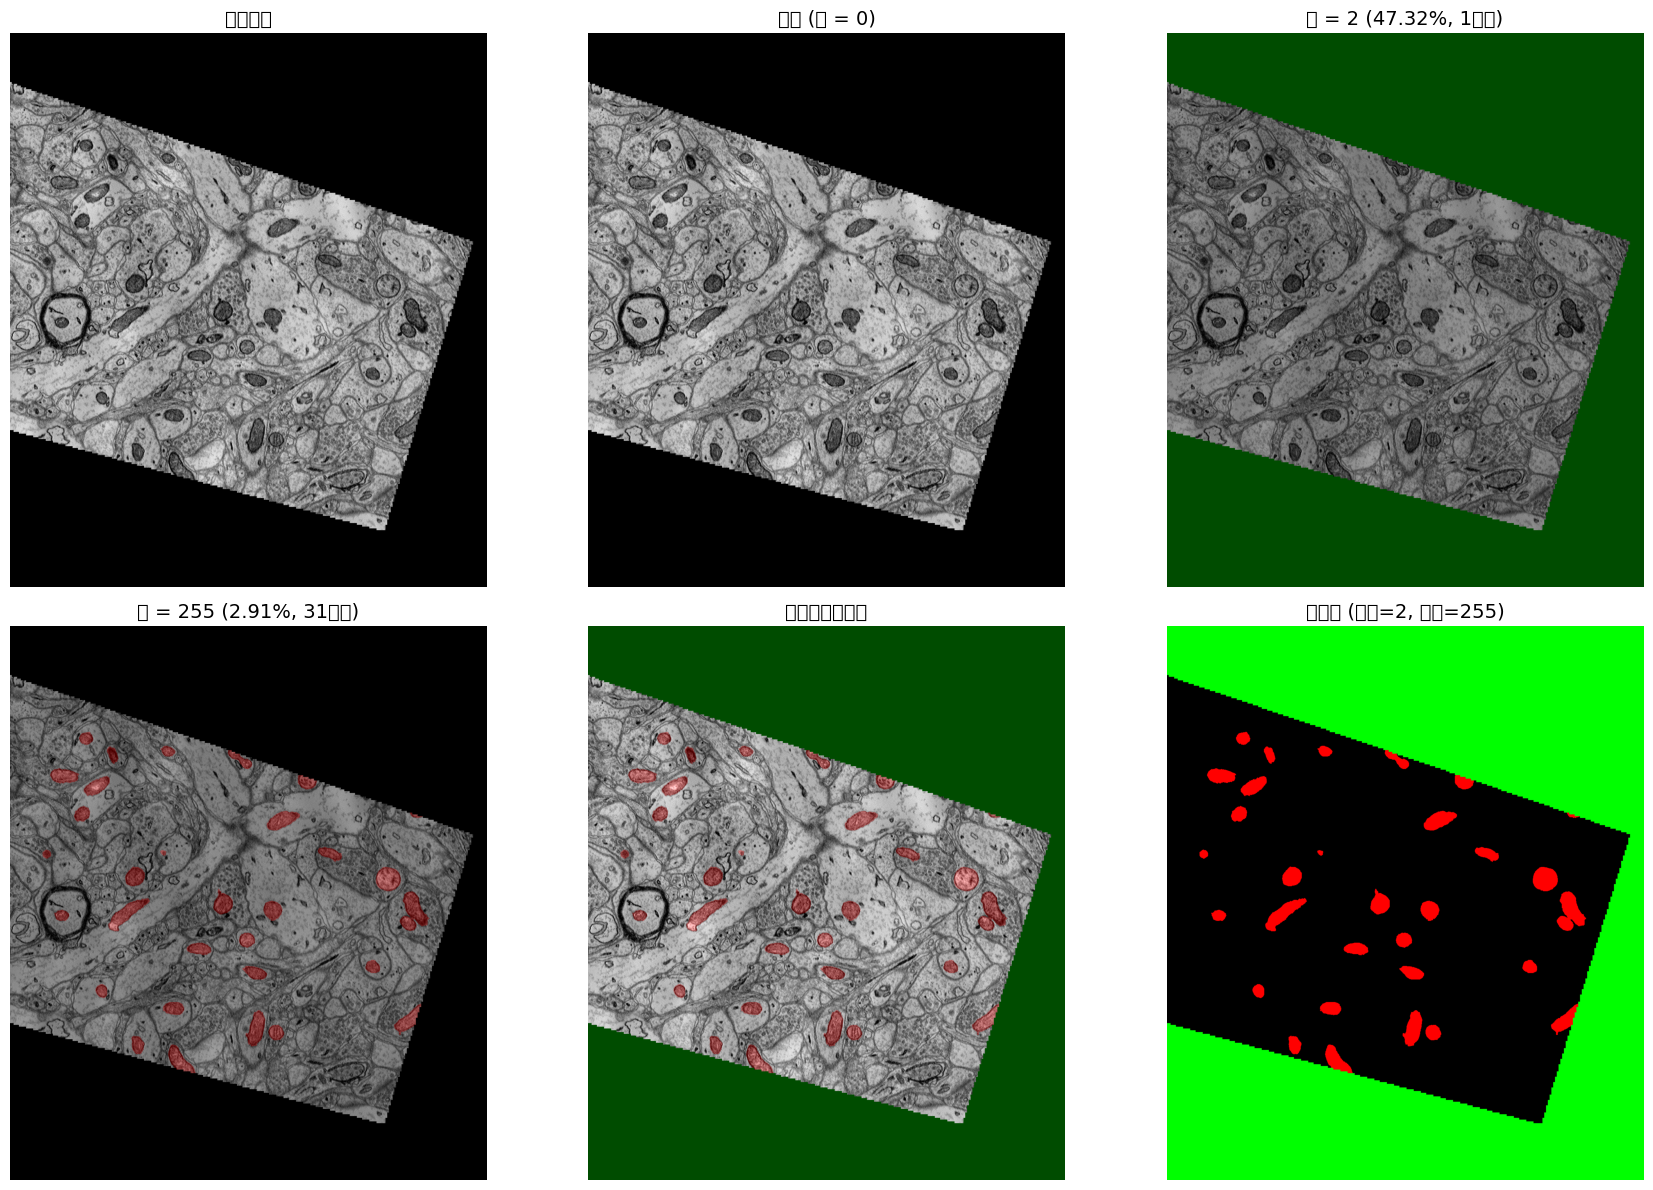


像素统计:
值 0: {'像素数': 1031075, '占比': '49.77%', '区域数': 'N/A'}
值 2: {'像素数': 980427, '占比': '47.32%', '区域数': 1}
值 255: {'像素数': 60200, '占比': '2.91%', '区域数': 31}

形态特征:

值 2 的区域特征:
  平均面积: 980427.00
  中位面积: 980427.00
  最小面积: 980427.00
  最大面积: 980427.00
  平均长宽比: 1.16
  中位长宽比: 1.16

值 255 的区域特征:
  平均面积: 1941.94
  中位面积: 1659.00
  最小面积: 188.00
  最大面积: 5253.00
  平均长宽比: 1.37
  中位长宽比: 1.30


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

def visualize_mask_values(image_path, mask_path, output_dir=None):
    """可视化掩码中不同像素值对应的区域"""
    
    # 读取图像和掩码
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图像: {image_path}")
        return None
        
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 读取掩码 - 尝试作为灰度图和彩色图读取
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_gray is None:
        print(f"无法读取掩码: {mask_path}")
        return None
    
    # 获取唯一值
    unique_values = np.unique(mask_gray)
    print(f"掩码中的唯一值: {unique_values}")
    
    # 创建多个子图 - 原始图像 + 每个值的叠加 + 全部叠加
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 显示原始图像
    axes[0].imshow(image_rgb)
    axes[0].set_title("原始图像", fontsize=14)
    axes[0].axis('off')
    
    # 为不同的掩码值创建单独的覆盖图
    color_map = {
        0: [0, 0, 0],      # 黑色 (背景)
        2: [0, 255, 0],    # 绿色
        255: [255, 0, 0]   # 红色
    }
    
    # 创建各个值的单独覆盖图
    for i, value in enumerate(unique_values):
        if value == 0:  # 背景单独处理
            axes[i+1].imshow(image_rgb)
            axes[i+1].set_title(f"背景 (值 = {value})", fontsize=14)
        else:
            # 创建该值的二值掩码
            binary_mask = (mask_gray == value).astype(np.uint8)
            
            # 计算该值的像素占比和区域数量
            pixel_count = np.sum(binary_mask)
            percentage = pixel_count / mask_gray.size * 100
            
            # 使用连通区域分析计算区域数量
            num_labels, _ = cv2.connectedComponents(binary_mask)
            region_count = num_labels - 1  # 减去背景
            
            # 创建彩色覆盖
            overlay = image_rgb.copy()
            color = color_map.get(value, [0, 0, 255])  # 默认蓝色
            
            # 创建彩色蒙版
            colored_mask = np.zeros_like(image_rgb)
            colored_mask[binary_mask == 1] = color
            
            # 叠加到原图，使用半透明效果
            overlay = cv2.addWeighted(overlay, 0.7, colored_mask, 0.3, 0)
            
            # 显示覆盖图像
            axes[i+1].imshow(overlay)
            axes[i+1].set_title(f"值 = {value} ({percentage:.2f}%, {region_count}区域)", fontsize=14)
        
        axes[i+1].axis('off')
    
    # 创建所有值的组合覆盖图
    combined_overlay = image_rgb.copy()
    
    # 按顺序添加不同颜色的区域 (先添加背景，再添加值2，最后添加值255)
    alpha = 0.3  # 透明度
    for value in sorted(unique_values, reverse=True):  # 倒序处理，确保较小的值不会覆盖较大的值
        if value != 0:  # 跳过背景
            binary_mask = (mask_gray == value).astype(np.uint8)
            color = color_map.get(value, [0, 0, 255])
            
            colored_mask = np.zeros_like(image_rgb)
            colored_mask[binary_mask == 1] = color
            
            # 叠加
            combined_overlay = cv2.addWeighted(combined_overlay, 1, colored_mask, alpha, 0)
    
    # 显示组合覆盖图
    axes[4].imshow(combined_overlay)
    axes[4].set_title("所有值组合覆盖", fontsize=14)
    axes[4].axis('off')
    
    # 显示纯掩码图像 (不同颜色)
    pure_mask = np.zeros_like(image_rgb)
    for value in unique_values:
        if value != 0:  # 跳过背景
            binary_mask = (mask_gray == value).astype(np.uint8)
            color = color_map.get(value, [0, 0, 255])
            pure_mask[binary_mask == 1] = color
    
    axes[5].imshow(pure_mask)
    axes[5].set_title("纯掩码 (绿色=2, 红色=255)", fontsize=14)
    axes[5].axis('off')
    
    plt.tight_layout()
    
    # 保存结果
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        filename = Path(image_path).stem
        save_path = os.path.join(output_dir, f"{filename}_mask_analysis.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"可视化结果已保存至: {save_path}")
    
    plt.show()
    
    # 为进一步分析，返回各值的像素计数和区域数量
    result = {}
    for value in unique_values:
        binary_mask = (mask_gray == value).astype(np.uint8)
        count = np.sum(binary_mask)
        percentage = count / mask_gray.size * 100
        
        # 计算连通区域
        if value != 0:
            num_labels, _ = cv2.connectedComponents(binary_mask)
            region_count = num_labels - 1
        else:
            region_count = "N/A"  # 背景区域数量不计算
        
        result[int(value)] = {
            "像素数": int(count),
            "占比": f"{percentage:.2f}%",
            "区域数": region_count
        }
    
    # 计算形态特征 (针对非背景值)
    morphology = {}
    for value in unique_values:
        if value == 0:
            continue
            
        binary_mask = (mask_gray == value).astype(np.uint8)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
        
        if num_labels > 1:  # 有至少一个区域
            areas = stats[1:, cv2.CC_STAT_AREA]  # 跳过背景
            widths = stats[1:, cv2.CC_STAT_WIDTH]
            heights = stats[1:, cv2.CC_STAT_HEIGHT]
            
            # 计算长宽比
            aspect_ratios = np.maximum(widths, heights) / np.maximum(1, np.minimum(widths, heights))
            
            morphology[int(value)] = {
                "平均面积": float(np.mean(areas)),
                "中位面积": float(np.median(areas)),
                "最小面积": float(np.min(areas)),
                "最大面积": float(np.max(areas)),
                "平均长宽比": float(np.mean(aspect_ratios)),
                "中位长宽比": float(np.median(aspect_ratios))
            }
    
    return {"像素统计": result, "形态特征": morphology}

# 使用示例
def analyze_image_mask_pair(image_path, mask_path, output_dir="mask_analysis"):
    print(f"\n分析图像: {image_path}")
    print(f"对应掩码: {mask_path}")
    
    stats = visualize_mask_values(image_path, mask_path, output_dir)
    
    if stats:
        print("\n像素统计:")
        for value, info in stats["像素统计"].items():
            print(f"值 {value}: {info}")
        
        print("\n形态特征:")
        for value, features in stats["形态特征"].items():
            print(f"\n值 {value} 的区域特征:")
            for k, v in features.items():
                print(f"  {k}: {v:.2f}" if isinstance(v, float) else f"  {k}: {v}")

# 运行分析
analyze_image_mask_pair(
    "dataset/Kasthuri++/Test_In/mask1065.png",  # 替换为您的图像路径
    "dataset/Kasthuri++/Test_Out/mask1065.png",  # 替换为您的掩码路径
    "analysis_output"  # 输出目录
)

##### 检测图片像素数值分布的封装自测代码，mask数据集背景标记为2

重要问题！！！    mask 像素值有三个  0   2   255
根据下面K的数据集得出， 2 是背景像素，所以所有的添加像素点的操作，尤其是对mask添加时，要注意添加的背景值是2，然后也不需要做任何的蒙版操作了，直接用2作为背景就可以了，就是mask值为2 对应的区域全都是背景黑色，其它区域就是前景！！

掩码中的唯一值: [0 1]
警告: 目标值 2 不在掩码中
掩码中的唯一值: [0 1]
值 0 的像素数量: 2020840 (97.54%)


C:\Users\leo\AppData\Local\Temp\ipykernel_29388\3246995921.py:65: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_29388\3246995921.py:65: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_29388\3246995921.py:65: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_29388\3246995921.py:65: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_29388\3246995921.py:65: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_29388\3246995921.py:65: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from cur

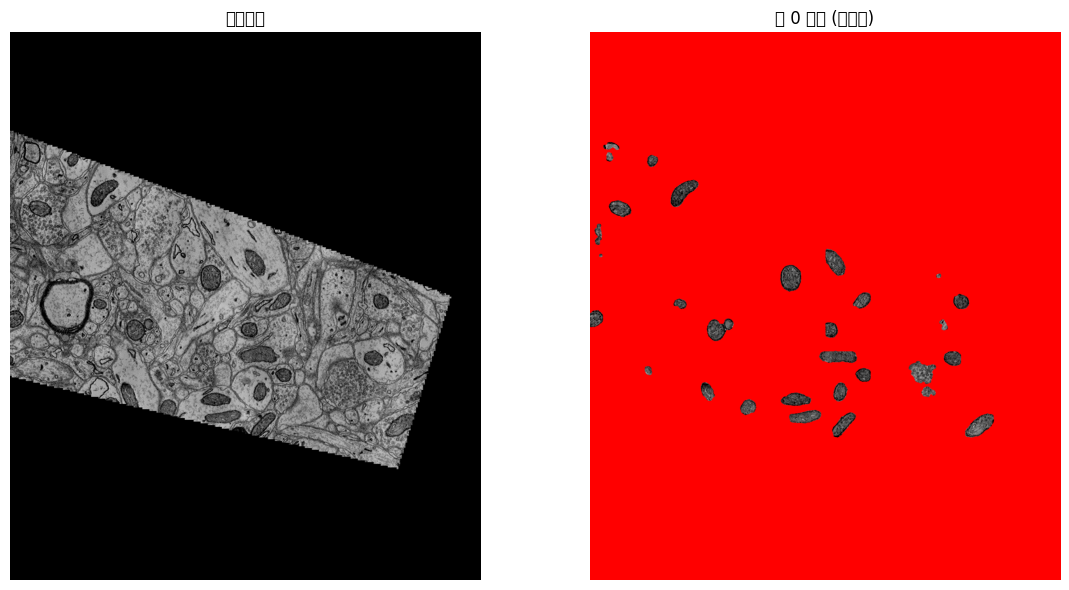

掩码中的唯一值: [0 1]
警告: 目标值 255 不在掩码中
=
掩码中的唯一值: [  0 255]
警告: 目标值 2 不在掩码中
掩码中的唯一值: [  0 255]
值 0 的像素数量: 706879 (89.88%)


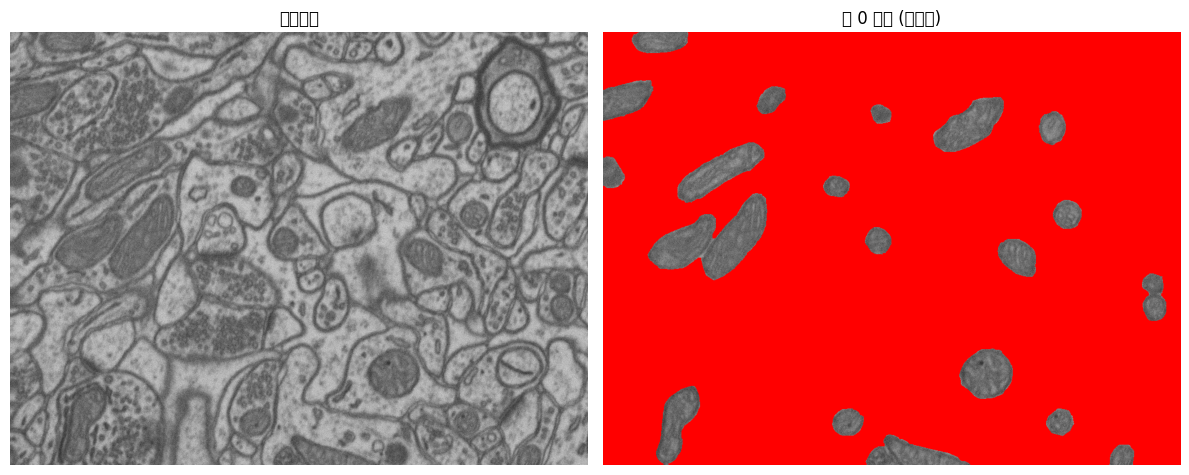

掩码中的唯一值: [ 43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215]
警告: 目标值 255 不在掩码中


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def highlight_mask_value(image_path, mask_path, target_value=2):
    """
    在图像上高亮显示掩码中特定值对应的区域，并使用plt显示结果
    
    参数:
        image_path: 原始图像路径
        mask_path: 掩码图像路径
        target_value: 要高亮的掩码值 (默认为2)
    """
    # 读取图像和掩码
    image = cv2.imread(image_path)
    if image is None:
        print(f"无法读取图像: {image_path}")
        return
    
    # 读取掩码
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"无法读取掩码: {mask_path}")
        return
    
    # 获取掩码中的唯一值
    unique_values = np.unique(mask)
    print(f"掩码中的唯一值: {unique_values}")
    
    if target_value not in unique_values:
        print(f"警告: 目标值 {target_value} 不在掩码中")
        return
    
    # 创建目标值的二值掩码
    binary_mask = (mask == target_value).astype(np.uint8)
    
    # 计算目标区域的像素数量和占比
    pixel_count = np.sum(binary_mask)
    percentage = pixel_count / mask.size * 100
    print(f"值 {target_value} 的像素数量: {pixel_count} ({percentage:.2f}%)")
    
    # 创建高亮图像
    highlighted_image = image.copy()
    
    # 将值为target_value的区域变为亮红色
    highlighted_image[binary_mask == 1] = [0, 0, 255]  # BGR格式：亮红色
    
    # 显示结果
    # 将BGR转换为RGB用于Matplotlib显示
    highlighted_rgb = cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    plt.imshow(image_rgb)
    plt.title("原始图像")
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(highlighted_rgb)
    plt.title(f"值 {target_value} 区域 (亮红色)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 使用示例
image_path1 = "test/mask1043_original.png"  # 替换为您的图像路径
mask_path1 = "test/mask1043_prediction_final.png"  # 替换为您的掩码路径

image_path2 = "dataset/Lucchi++/Test_In/mask0004.png"  # 替换为您的图像路径
mask_path2 = "dataset/Lucchi++/Test_Out/4.png"  # 替换为您的掩码路径

# 显示值为2的区域为亮红色
highlight_mask_value(image_path1, mask_path1, target_value=2)
highlight_mask_value(image_path1, mask_path1, target_value=0)
highlight_mask_value(image_path1, mask_path1, target_value=255)
print("=")
highlight_mask_value(image_path2, mask_path2, target_value=2)
highlight_mask_value(image_path2, mask_path2, target_value=0)
highlight_mask_value(image_path2, image_path2, target_value=255)

##### 判断图片通道数的函数模块(可用)

掩码含有透明通道，使用UNCHANGED模式加载

===== 原始图像 分析结果 (2025-04-13 21:03:06) =====
数据类型: NumPy数组 (uint8)

图像属性:
形状: (768, 1024, 3) (维度: 3)
分辨率: 1024x768
图像类型: RGB/BGR图像
通道数: 3
颜色空间: BGR (如OpenCV加载) 或 RGB (如PIL、matplotlib加载)

像素统计:
值范围: [42.0, 221.0]
平均值: 132.3412, 中位数: 131.0000, 标准差: 30.0937
零值: 0 像素 (0.00%)
非零值: 2359296 像素 (100.00%)

通道分析:
  蓝/红(B/R): 范围[42.00, 221.00], 平均值: 132.34, 标准差: 30.09
  绿(G): 范围[42.00, 221.00], 平均值: 132.34, 标准差: 30.09
  红/蓝(R/B): 范围[42.00, 221.00], 平均值: 132.34, 标准差: 30.09

内存占用: 2359296 字节 (2.25 MB)

===== 掩码 分析结果 (2025-04-13 21:03:06) =====
数据类型: NumPy数组 (uint8)

图像属性:
形状: (768, 1024, 4) (维度: 3)
分辨率: 1024x768
图像类型: RGBA/BGRA图像
通道数: 4
颜色空间: BGRA 或 RGBA (带Alpha通道)

像素统计:
值范围: [0.0, 255.0]
平均值: 82.5865, 中位数: 0.0000, 标准差: 119.3274
零值: 2126925 像素 (67.61%)
非零值: 1018803 像素 (32.39%)

Alpha通道: 不透明 (Alpha通道值很高)

内存占用: 3145728 字节 (3.00 MB)


C:\Users\leo\AppData\Local\Temp\ipykernel_17572\1818199454.py:126: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_17572\1818199454.py:126: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_17572\1818199454.py:126: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_17572\1818199454.py:126: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_17572\1818199454.py:126: UserWarning: Glyph 25513 (\N{CJK UNIFIED IDEOGRAPH-63A9}) missing from current font.
  plt.tight_layout()
C:\Users\leo\AppData\Local\Temp\ipykernel_17572\1818199454.py:126: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing fr

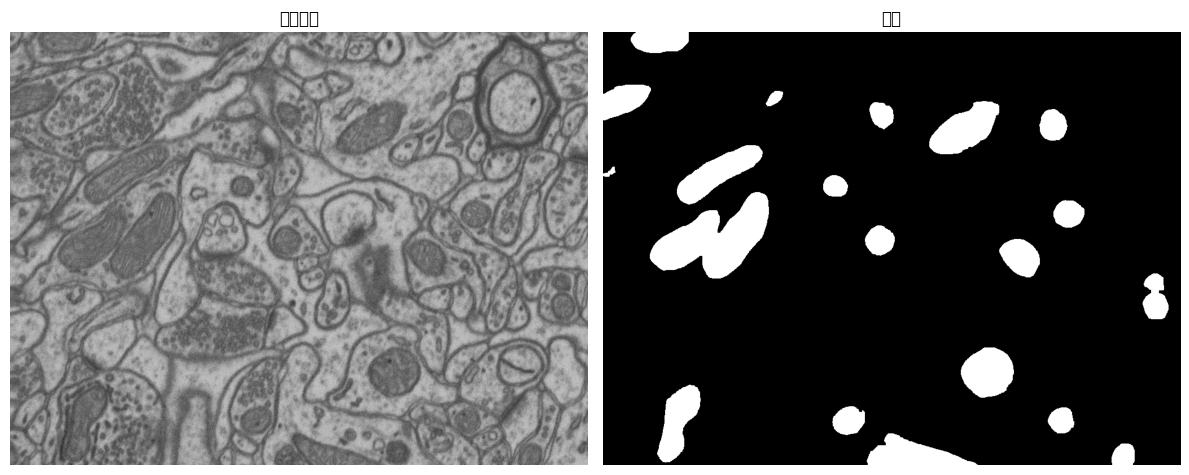

掩码含有透明通道，使用UNCHANGED模式加载

===== 原始图像 分析结果 (2025-04-13 21:03:06) =====
数据类型: NumPy数组 (uint8)

图像属性:
形状: (768, 1024, 3) (维度: 3)
分辨率: 1024x768
图像类型: RGB/BGR图像
通道数: 3
颜色空间: BGR (如OpenCV加载) 或 RGB (如PIL、matplotlib加载)

像素统计:
值范围: [40.0, 220.0]
平均值: 132.4355, 中位数: 131.0000, 标准差: 30.2714
零值: 0 像素 (0.00%)
非零值: 2359296 像素 (100.00%)

通道分析:
  蓝/红(B/R): 范围[40.00, 220.00], 平均值: 132.44, 标准差: 30.27
  绿(G): 范围[40.00, 220.00], 平均值: 132.44, 标准差: 30.27
  红/蓝(R/B): 范围[40.00, 220.00], 平均值: 132.44, 标准差: 30.27

内存占用: 2359296 字节 (2.25 MB)

===== 掩码 分析结果 (2025-04-13 21:03:06) =====
数据类型: NumPy数组 (uint8)

图像属性:
形状: (768, 1024, 4) (维度: 3)
分辨率: 1024x768
图像类型: RGBA/BGRA图像
通道数: 4
颜色空间: BGRA 或 RGBA (带Alpha通道)

像素统计:
值范围: [0.0, 255.0]
平均值: 83.1507, 中位数: 0.0000, 标准差: 119.5382
零值: 2119965 像素 (67.39%)
非零值: 1025763 像素 (32.61%)

Alpha通道: 不透明 (Alpha通道值很高)

内存占用: 3145728 字节 (3.00 MB)


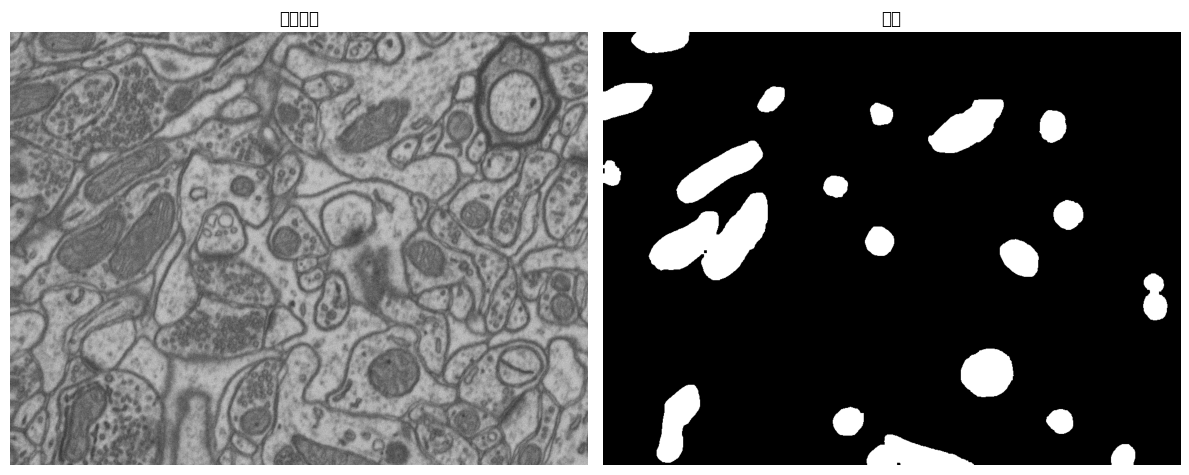

(array([[[141, 141, 141],
         [136, 136, 136],
         [143, 143, 143],
         ...,
         [142, 142, 142],
         [129, 129, 129],
         [156, 156, 156]],
 
        [[132, 132, 132],
         [124, 124, 124],
         [145, 145, 145],
         ...,
         [118, 118, 118],
         [115, 115, 115],
         [130, 130, 130]],
 
        [[128, 128, 128],
         [124, 124, 124],
         [139, 139, 139],
         ...,
         [110, 110, 110],
         [104, 104, 104],
         [121, 121, 121]],
 
        ...,
 
        [[116, 116, 116],
         [111, 111, 111],
         [109, 109, 109],
         ...,
         [173, 173, 173],
         [188, 188, 188],
         [184, 184, 184]],
 
        [[108, 108, 108],
         [108, 108, 108],
         [108, 108, 108],
         ...,
         [188, 188, 188],
         [192, 192, 192],
         [180, 180, 180]],
 
        [[101, 101, 101],
         [ 90,  90,  90],
         [102, 102, 102],
         ...,
         [186, 186, 186],
  

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

def load_and_analyze_images(image_path=None, mask_path=None, image_array=None, mask_array=None):
    """
    加载图像和掩码并分析其属性，支持文件路径或直接提供NumPy数组
    
    Args:
        image_path: 原始图像路径
        mask_path: 掩码图像路径
        image_array: 直接提供的图像NumPy数组
        mask_array: 直接提供的掩码NumPy数组
        
    Returns:
        加载的图像和掩码，以及它们的分析信息
    """
    image = None
    mask = None
    
    # 处理图像 - 从文件加载或使用提供的数组
    if image_array is not None:
        print("使用提供的图像数组")
        image = image_array
    elif image_path is not None:
        if not os.path.exists(image_path):
            print(f"错误: 图像文件不存在 - {image_path}")
        else:
            # 加载图像
            image = cv2.imread(image_path)
            
            # 根据文件扩展名决定是否需要考虑透明通道
            if image_path.lower().endswith(('.png', '.tiff', '.tif')):
                image_with_alpha = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # 保留透明通道
                if image_with_alpha is not None and len(image_with_alpha.shape) > 2 and image_with_alpha.shape[-1] == 4:
                    print("图像含有透明通道，使用UNCHANGED模式加载")
                    image = image_with_alpha
    
    # 处理掩码 - 从文件加载或使用提供的数组
    if mask_array is not None:
        print("使用提供的掩码数组")
        mask = mask_array
    elif mask_path is not None:
        if not os.path.exists(mask_path):
            print(f"错误: 掩码文件不存在 - {mask_path}")
        else:
            # 对于掩码，我们尝试以灰度模式和彩色模式都加载一次，确保正确处理
            mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # 以灰度模式加载
            mask_color = cv2.imread(mask_path)  # 以彩色模式加载
            
            if mask_path.lower().endswith(('.png', '.tiff', '.tif')):
                mask_with_alpha = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                if mask_with_alpha is not None and len(mask_with_alpha.shape) > 2 and mask_with_alpha.shape[-1] == 4:
                    print("掩码含有透明通道，使用UNCHANGED模式加载")
                    mask = mask_with_alpha
                else:
                    # 判断是否是单通道或多通道掩码
                    if mask_gray is not None and (mask_color is None or np.array_equal(cv2.cvtColor(mask_color, cv2.COLOR_BGR2GRAY), mask_gray)):
                        mask = mask_gray  # 单通道掩码
                    else:
                        mask = mask_color  # 多通道掩码
            else:
                if mask_gray is not None:
                    mask = mask_gray
                else:
                    mask = mask_color
    
    # 检查是否成功加载/提供
    if image is None and mask is None:
        print("错误: 未提供有效的图像和掩码")
        return None, None, None, None
    
    # 分析图像和掩码
    image_info = None
    mask_info = None
    
    if image is not None:
        image_info = analyze_image(image, "原始图像")
    
    if mask is not None:
        mask_info = analyze_image(mask, "掩码")
    
    # 可视化图像和掩码（如果都存在）
    if image is not None and mask is not None:
        visualize_image_and_mask(image, mask)
    elif image is not None:
        visualize_single_image(image, "原始图像")
    elif mask is not None:
        visualize_single_image(mask, "掩码")
    
    return image, mask, image_info, mask_info

def visualize_image_and_mask(image, mask):
    """
    可视化图像和掩码
    """
    # 将BGR转为RGB用于显示
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_display = image
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    if len(image_display.shape) == 3 and image_display.shape[2] == 4:
        # 有Alpha通道的情况
        plt.imshow(image_display[..., :3])
    else:
        plt.imshow(image_display, cmap='gray' if len(image_display.shape) == 2 else None)
    plt.title("原始图像")
    plt.axis('off')
    
    plt.subplot(122)
    if len(mask.shape) == 3 and mask.shape[2] >= 3:
        mask_display = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) if mask.shape[2] == 3 else mask[..., :3]
        plt.imshow(mask_display)
    else:
        # 对于单通道掩码，使用colormap显示不同的值
        plt.imshow(mask, cmap='viridis')
    plt.title("掩码")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_single_image(image, title):
    """
    可视化单个图像
    """
    plt.figure(figsize=(8, 6))
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        # BGR转RGB显示
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif len(image.shape) == 3 and image.shape[2] == 4:
        # 带Alpha通道的图像
        plt.imshow(cv2.cvtColor(image[..., :3], cv2.COLOR_BGR2RGB))
    else:
        # 灰度或其他单通道图像
        plt.imshow(image, cmap='gray')
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def analyze_image(image, image_name="Image"):
    """
    全面分析图像的属性和信息，支持文件加载的图像和NumPy数组
    
    Args:
        image: 输入图像，可以是任何格式（RGB、灰度、RGBA等）或NumPy数组
        image_name: 图像的名称标识，用于输出
        
    Returns:
        包含图像属性的字典
    """
    if image is None:
        print(f"{image_name} 是空值 (None)")
        return None
    
    info = {}
    
    # 判断是否为NumPy数组及其类型
    info["is_numpy"] = isinstance(image, np.ndarray)
    if not info["is_numpy"]:
        print(f"警告: {image_name} 不是NumPy数组，而是 {type(image)}")
        # 尝试转换为NumPy数组
        try:
            image = np.array(image)
            info["is_numpy"] = True
            info["converted_from"] = str(type(image))
        except:
            print(f"错误: 无法将 {type(image)} 转换为NumPy数组")
            return {"error": f"无法分析非NumPy数组类型 {type(image)}"}
    
    # 基本属性
    info["shape"] = image.shape
    info["ndim"] = image.ndim
    info["dtype"] = str(image.dtype)
    info["size_bytes"] = image.nbytes
    info["size_mb"] = image.nbytes / (1024 * 1024)
    
    # 检查是否为浮点数组，并记录范围
    is_float = np.issubdtype(image.dtype, np.floating)
    info["is_float"] = is_float
    if is_float:
        info["float_range"] = f"[{np.min(image):.6f}, {np.max(image):.6f}]"
        
        # 检查是否规范化到[0,1]范围
        if np.min(image) >= 0 and np.max(image) <= 1:
            info["normalized"] = "可能规范化到[0,1]范围"
        elif np.min(image) >= -1 and np.max(image) <= 1:
            info["normalized"] = "可能规范化到[-1,1]范围"
        else:
            info["normalized"] = "未规范化或使用其他范围"
    
    # 根据维度和形状分析图像类型
    if image.ndim == 2:
        info["image_type"] = "灰度图/单通道图"
        info["height"] = image.shape[0]
        info["width"] = image.shape[1]
        info["resolution"] = f"{image.shape[1]}x{image.shape[0]}"
        info["channels"] = 1
        info["colorspace"] = "灰度"
    elif image.ndim == 3:
        info["height"] = image.shape[0]
        info["width"] = image.shape[1]
        info["resolution"] = f"{image.shape[1]}x{image.shape[0]}"
        
        channels = image.shape[2]
        info["channels"] = channels
        
        if channels == 1:
            info["image_type"] = "单通道图"
            info["colorspace"] = "灰度"
        elif channels == 3:
            info["image_type"] = "RGB/BGR图像"
            # OpenCV默认是BGR，但如果是从其他地方加载的NumPy数组，可能是RGB
            info["colorspace"] = "BGR (如OpenCV加载) 或 RGB (如PIL、matplotlib加载)"
            
            # 分析各个通道
            channel_names = ["蓝/红(B/R)", "绿(G)", "红/蓝(R/B)"]
            info["channel_stats"] = {}
            for i in range(3):
                channel = image[:,:,i]
                stats = {
                    "min": float(np.min(channel)),
                    "max": float(np.max(channel)),
                    "mean": float(np.mean(channel)),
                    "std": float(np.std(channel))
                }
                info["channel_stats"][channel_names[i]] = stats
                
        elif channels == 4:
            info["image_type"] = "RGBA/BGRA图像"
            info["colorspace"] = "BGRA 或 RGBA (带Alpha通道)"
            
            # 分析Alpha通道
            alpha_channel = image[:,:,3]
            info["alpha_min"] = float(np.min(alpha_channel))
            info["alpha_max"] = float(np.max(alpha_channel))
            info["alpha_mean"] = float(np.mean(alpha_channel))
            
            # 检查Alpha通道用法
            if is_float:
                alpha_threshold = 0.99 if np.max(alpha_channel) <= 1.0 else 254
            else:
                alpha_threshold = 254
                
            if np.min(alpha_channel) >= alpha_threshold and np.max(alpha_channel) >= alpha_threshold:
                info["transparency"] = "不透明 (Alpha通道值很高)"
            elif np.min(alpha_channel) <= 0.01 and np.max(alpha_channel) <= 0.01:
                info["transparency"] = "完全透明 (Alpha通道值很低)"
            else:
                transparent_pixels = np.sum(alpha_channel < alpha_threshold)
                transparent_percentage = (transparent_pixels / alpha_channel.size) * 100
                info["transparency"] = f"部分透明 ({transparent_percentage:.2f}% 的像素含有透明度)"
        else:
            info["image_type"] = f"多通道图像 ({channels}通道)"
            info["colorspace"] = f"未知 ({channels}通道)"
    elif image.ndim == 4:
        # 可能是批量图像，如(batch_size, height, width, channels)
        info["image_type"] = "批量图像或视频帧"
        info["batch_size"] = image.shape[0]
        info["height"] = image.shape[1]
        info["width"] = image.shape[2]
        info["resolution"] = f"{image.shape[2]}x{image.shape[1]}"
        
        if image.shape[3] == 1:
            info["channels"] = 1
            info["colorspace"] = "批量灰度图"
        elif image.shape[3] == 3:
            info["channels"] = 3
            info["colorspace"] = "批量RGB/BGR图"
        elif image.shape[3] == 4:
            info["channels"] = 4
            info["colorspace"] = "批量RGBA/BGRA图"
        else:
            info["channels"] = image.shape[3]
            info["colorspace"] = f"批量多通道图 ({image.shape[3]}通道)"
    else:
        info["image_type"] = f"非标准图像格式 (维度: {image.ndim})"
        info["shape_description"] = "x".join([str(dim) for dim in image.shape])
    
    # 数值统计
    if image.size > 0:  # 非空数组
        info["min_value"] = float(np.min(image))
        info["max_value"] = float(np.max(image))
        info["mean_value"] = float(np.mean(image))
        info["median_value"] = float(np.median(image))
        info["std_dev"] = float(np.std(image))
        
        # 检查是否有NaN或Inf值
        info["has_nan"] = np.isnan(image).any()
        info["has_inf"] = np.isinf(image).any()
        if info["has_nan"]:
            info["nan_count"] = int(np.isnan(image).sum())
            info["nan_percentage"] = (info["nan_count"] / image.size) * 100
        if info["has_inf"]:
            info["inf_count"] = int(np.isinf(image).sum())
            info["inf_percentage"] = (info["inf_count"] / image.size) * 100
        
        # 检查0值和非0值的占比
        info["zero_count"] = int(np.sum(image == 0))
        info["non_zero_count"] = int(np.sum(image != 0))
        info["zero_percentage"] = (info["zero_count"] / image.size) * 100
        info["non_zero_percentage"] = (info["non_zero_count"] / image.size) * 100
    
        # 分析唯一值 (对于灰度图、掩码等)
        if image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
            # 扁平化处理，对于单通道图像
            flat_img = image.flatten() if image.ndim == 2 else image[:,:,0].flatten()
            
            # 对于大图像，可能需要采样来计算唯一值
            if flat_img.size > 1000000:  # 超过百万像素时采样
                sample_size = min(1000000, flat_img.size // 10)
                sample_indices = np.random.choice(flat_img.size, sample_size, replace=False)
                unique_sample = np.unique(flat_img[sample_indices])
                info["unique_values_sampled"] = True
                info["unique_values_count_estimate"] = len(unique_sample)
                
                if len(unique_sample) <= 30:
                    info["unique_values_sample"] = unique_sample.tolist()
                    
                    # 如果采样中唯一值少，尝试计算完整的唯一值
                    if len(unique_sample) <= 10:
                        unique_values = np.unique(flat_img)
                        info["unique_values"] = unique_values.tolist()
                        info["num_unique_values"] = len(unique_values)
                        info["unique_values_sampled"] = False
            else:
                # 直接计算唯一值
                unique_values = np.unique(flat_img)
                info["unique_values"] = unique_values.tolist()
                info["num_unique_values"] = len(unique_values)
                
                if len(unique_values) <= 2:
                    info["image_type"] = "二值图 (值: " + str(unique_values.tolist()) + ")"
                elif len(unique_values) <= 30:
                    info["image_type"] = "索引图/标签图 (值: " + str(unique_values.tolist()) + ")"
                    
                    # 计算每个标签的像素比例
                    if len(unique_values) <= 15:  # 对于不太多的标签值
                        label_stats = {}
                        for val in unique_values:
                            count = np.sum(flat_img == val)
                            percentage = (count / flat_img.size) * 100
                            label_stats[float(val) if is_float else int(val)] = {
                                "count": int(count),
                                "percentage": float(percentage)
                            }
                        info["label_stats"] = label_stats
    
    # 处理可能的数值精度问题
    # 检查像素值是否接近整数值(表明可能是按0-255缩放的浮点图像)
    if is_float and image.size > 0:
        # 采样一部分像素
        sample = image.flatten()[:10000] if image.size > 10000 else image.flatten()
        # 计算与最近整数的差
        diff_to_int = np.abs(sample - np.round(sample))
        # 如果大多数值与整数非常接近
        if np.mean(diff_to_int) < 1e-5:
            info["pixel_precision"] = "接近整数值的浮点数 (可能是缩放后的整数图像)"
            
            # 检查是否是0-1范围内的值，但实际上可能是归一化的0-255
            if np.max(sample) <= 1.0 and np.min(sample) >= 0:
                rounded_to_255 = np.round(sample * 255)
                diff_to_255scale = np.abs(sample * 255 - rounded_to_255)
                if np.mean(diff_to_255scale) < 1e-3:
                    info["normalization"] = "可能是归一化到[0,1]范围的0-255图像"
    
    # 打印分析结果
    time_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\n===== {image_name} 分析结果 ({time_str}) =====")
    
    print(f"数据类型: NumPy数组 ({info['dtype']})")
    if "is_float" in info and info["is_float"]:
        print(f"浮点类型: 是 - 范围{info['float_range']}")
        if "normalized" in info:
            print(f"归一化状态: {info['normalized']}")
            
    print(f"\n图像属性:")
    print(f"形状: {info['shape']} (维度: {info['ndim']})")
    
    if "resolution" in info:
        print(f"分辨率: {info['resolution']}")
    
    if "image_type" in info:
        print(f"图像类型: {info['image_type']}")
    
    if "channels" in info:
        print(f"通道数: {info['channels']}")
        print(f"颜色空间: {info['colorspace']}")
    
    if "batch_size" in info:
        print(f"批量大小: {info['batch_size']}")
    
    print(f"\n像素统计:")
    if "min_value" in info:
        print(f"值范围: [{info['min_value']}, {info['max_value']}]")
        print(f"平均值: {info['mean_value']:.4f}, 中位数: {info['median_value']:.4f}, 标准差: {info['std_dev']:.4f}")
        
    if "has_nan" in info and info["has_nan"]:
        print(f"警告: 包含 {info['nan_count']} 个NaN值 ({info['nan_percentage']:.2f}%)")
    
    if "has_inf" in info and info["has_inf"]:
        print(f"警告: 包含 {info['inf_count']} 个Inf值 ({info['inf_percentage']:.2f}%)")
    
    if "zero_percentage" in info:
        print(f"零值: {info['zero_count']} 像素 ({info['zero_percentage']:.2f}%)")
        print(f"非零值: {info['non_zero_count']} 像素 ({info['non_zero_percentage']:.2f}%)")
    
    if "pixel_precision" in info:
        print(f"像素精度说明: {info['pixel_precision']}")
        if "normalization" in info:
            print(f"  {info['normalization']}")
    
    # 打印通道统计信息
    if "channel_stats" in info:
        print("\n通道分析:")
        for channel_name, stats in info["channel_stats"].items():
            print(f"  {channel_name}: 范围[{stats['min']:.2f}, {stats['max']:.2f}], 平均值: {stats['mean']:.2f}, 标准差: {stats['std']:.2f}")
    
    if "transparency" in info:
        print(f"\nAlpha通道: {info['transparency']}")
    
    # 打印唯一值信息
    if "unique_values_sampled" in info and info["unique_values_sampled"]:
        print(f"\n唯一值估计(采样): 约 {info['unique_values_count_estimate']} 个不同值")
        if "unique_values_sample" in info:
            print(f"唯一值样本: {info['unique_values_sample']}")
    elif "num_unique_values" in info:
        print(f"\n唯一值数量: {info['num_unique_values']}")
        if "unique_values" in info and len(info["unique_values"]) <= 30:
            print(f"唯一值: {info['unique_values']}")
    
    if "label_stats" in info:
        print("\n标签分布:")
        for label, stats in info["label_stats"].items():
            print(f"  标签值 {label}: {stats['count']} 像素 ({stats['percentage']:.2f}%)")
    
    print(f"\n内存占用: {info['size_bytes']} 字节 ({info['size_mb']:.2f} MB)")
    print("================================================")
    
    return info

# 使用示例

# 1. 从文件加载图像
def analyze_from_files(image_path ,mask_path ):

    image, mask, image_info, mask_info = load_and_analyze_images(image_path, mask_path)
    return image, mask, image_info, mask_info

# 2. 分析NumPy数组
def analyze_numpy_array(array, name="NumPy数组"):
    info = analyze_image(array, name)
    visualize_single_image(array, name)
    return info

# 运行分析
image_path1 = "dataset/Lucchi++/Test_In/mask0000.png"
mask_path1 = "dataset/Lucchi++/Test_Out/0.png"

image_path2 = "dataset/Lucchi++/Test_In/mask0002.png"
mask_path2 = "dataset/Lucchi++/Test_Out/2.png"

analyze_from_files(image_path1, mask_path1)

analyze_from_files(image_path2, mask_path2)
# 可以直接分析NumPy数组
# 示例: 创建一个随机浮点数NumPy数组并分析
# random_array = np.random.rand(256, 256, 3)  # 创建一个随机RGB浮点数组
# random_array_info = analyze_numpy_array(random_array, "随机浮点数组")

# 示例: 创建一个索引标签图并分析
# label_array = np.zeros((200, 200), dtype=np.uint8)
# label_array[50:100, 50:100] = 1
# label_array[100:150, 100:150] = 2
# label_array_info = analyze_numpy_array(label_array, "标签图数组")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
这种颜色空间转换不会导致训练带来偏差，只是改变了通道的顺序（从BGR变为RGB），没有修改像素值本身,因此这种转换是允许的。

# 4.2 全新Unet流程的完善架构(可用)


In [2]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import gc

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import UNet
from functions.data import SegmentationDataset
from functions.imagePreprocessing import ImagePreprocessor


In [3]:
# train_data, test_data = prepare_dataset("Kasthuri++")
train_data, test_data = prepare_dataset("Lucchi++")

Train Data (Lucchi++): [{'image': 'dataset\\Lucchi++\\Train_In\\mask0000.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\0.png', 'index': 0}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0001.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\1.png', 'index': 1}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0002.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\2.png', 'index': 2}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0003.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\3.png', 'index': 3}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0004.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\4.png', 'index': 4}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0005.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\5.png', 'index': 5}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0006.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\6.png', 'index': 6}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0007.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\7.png', 'index': 7}, {'image'

#### 执行预处理并保存处理后的数据集

In [4]:
# 第一次运行时：预处理并保存
train_dataset = SegmentationDataset(
    data_list=train_data,
    patch_size=256,
    stride=128,
    preProcess=True,  # 启用预处理

)

test_dataset = SegmentationDataset(
    data_list=test_data,
    patch_size=256,
    stride=128,
    preProcess=True,  # 启用预处理

)



开始数据集预处理...


处理图像: 100%|██████████| 165/165 [00:16<00:00, 10.07it/s]


数据集预处理完成，共生成 6027 个patch
开始数据集预处理...


处理图像: 100%|██████████| 165/165 [00:18<00:00,  8.95it/s]

数据集预处理完成，共生成 5961 个patch


In [5]:
def get_optimized_loaders(train_dataset, test_dataset, batch_size=16, num_workers=4, prefetch_factor=2):
    """创建优化的数据加载器"""
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,  # 增加工作线程
        pin_memory=True,  # 使用固定内存加速CPU到GPU的数据传输
        prefetch_factor=prefetch_factor,  # 预取因子
        persistent_workers=True  # 保持工作线程存活
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True
    )
    
    return train_loader, test_loader

In [6]:
# 创建数据加载器
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=8,
#     shuffle=True,
#     num_workers=4
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=8,
#     shuffle=True,
#     num_workers=4
#     )

train_loader, test_loader = get_optimized_loaders(
    train_dataset, 
    test_dataset, 
    batch_size=32,  # 增加批大小
    num_workers=4
)

#### 直接load已有数据集，跳过预处理(出现难以处理的bug，回退版本，此功能暂时搁置)

In [29]:
# 后续运行：直接加载预处理数据
train_dataset_cached = SegmentationDataset(
    data_list=train_data,
    patch_size=256,
    stride=128,
    skip_preprocessing=True,  # 跳过预处理
    processed_data_dir="./processed_data/train"  # 直接从保存的目录加载
)

test_dataset_cached = SegmentationDataset(  
    data_list=test_data, 
    patch_size=256,
    stride=128,
    skip_preprocessing=True,  # 跳过预处理
    processed_data_dir="./processed_data/test"  # 直接从保存的目录加载
    )

# train_loader_cached = DataLoader(
#     train_dataset_cached,
#     batch_size=8,
#     shuffle=True,
#     num_workers=4
# )

# test_loader_cached = DataLoader(
#     test_dataset_cached,
#     batch_size=8,
#     shuffle=True,
#     num_workers=4
# )

train_loader, test_loader = get_optimized_loaders(
    train_dataset_cached, 
    test_dataset_cached, 
    batch_size=32,  # 增加批大小
    num_workers=4
)


TypeError: SegmentationDataset.__init__() got an unexpected keyword argument 'skip_preprocessing'

#### 训练开始 4.2

In [8]:
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    # Convert predictions to binary
    pred_mask = (pred_mask > threshold).float()

    # Calculate intersection and union
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Calculate Dice coefficient
    dice = (2. * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)

    return iou.item(), dice.item()

def optimized_train_model(model, train_loader, val_loader, num_epochs=50, device="cuda", 
                          batch_accumulation=1, pin_memory=True):
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    # 设置异步数据加载
    train_loader.pin_memory = pin_memory
    val_loader.pin_memory = pin_memory
    
    # 初始清理内存
    if device == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        batch_count = 0
        
        optimizer.zero_grad()  # 外部清零梯度
        
        for batch_idx, batch in enumerate(train_loader):
            # 使用梯度累积减少GPU内存使用
            patches = batch['patches'].to(device, non_blocking=True)
            mask_patches = batch['mask_patches'].to(device, non_blocking=True)
            
            outputs = model(patches)
            loss = criterion(outputs, mask_patches) / batch_accumulation
            
            loss.backward()
            
            # 梯度累积：每累积batch_accumulation个批次更新一次权重
            if (batch_idx + 1) % batch_accumulation == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            iou, dice = calculate_metrics(pred_masks, mask_patches)
            
            train_loss += loss.item() * batch_accumulation
            train_iou += iou
            train_dice += dice
            batch_count += 1
            
            # 在内部也进行内存清理
            del patches, mask_patches, outputs, pred_masks, loss
            
            # 定期清理GPU内存
            if batch_idx % 10 == 0 and device == "cuda":
                torch.cuda.empty_cache()
        
        # 处理剩余的梯度
        if batch_count % batch_accumulation != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # 计算平均值
        train_loss /= batch_count
        train_iou /= batch_count
        train_dice /= batch_count
        
        # 训练完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_count = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device, non_blocking=True)
                mask_patches = batch['mask_patches'].to(device, non_blocking=True)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                iou, dice = calculate_metrics(pred_masks, mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
                val_count += 1
                
                del patches, mask_patches, outputs, pred_masks, loss
        
        val_loss /= val_count
        val_iou /= val_count
        val_dice /= val_count
        
        # 验证完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 简洁输出格式
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        print('------------------------------------------------------------')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_iou.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')   
   
def reconstruct_from_patches(patches, positions, original_size, patch_size, stride):
    """
    从patches重建完整图像
    
    参数:
        patches: 预测的patch列表
        positions: 每个patch的左上角坐标列表，格式为[(y1, x1), (y2, x2), ...]
        original_size: 原始图像尺寸，格式为(height, width)
        patch_size: patch的大小
        stride: patch滑动的步长

    返回:
        reconstructed: 重建后的完整图像
    """
    h, w = original_size
    reconstructed = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)
    
    for patch, (y, x) in zip(patches, positions):
        patch_h = min(patch_size, h - y)
        patch_w = min(patch_size, w - x)
        reconstructed[y:y+patch_h, x:x+patch_w] += patch[:patch_h, :patch_w]
        count[y:y+patch_h, x:x+patch_w] += 1
    
    # 处理重叠区域
    count[count == 0] = 1
    reconstructed /= count
    return reconstructed

# 加载保存的模型
def load_model(model_path, device="cuda"):
    """
    加载保存的模型
    
    参数:
        model_path: 模型文件路径
        device: 使用的设备，默认为cuda
    
    返回:
        model: 加载的模型
    """
    # 检查设备
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA不可用，将使用CPU")
        device = "cpu"
    
    # 初始化模型架构
    model = UNet(num_classes=1)
    
    # 加载模型权重
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    
    # 将模型转移到指定设备
    model = model.to(device)
    
    # 设置为评估模式
    model.eval()
    
    print(f"模型已从 {model_path} 加载")
    
    return model

#3.28更新predict函数，把多余的预处理和部分无用代码删除
def predict(model, image, mask=None, device="cuda", patch_size=256, stride=None):
    """
    核心预测函数：接收预处理后的图像，执行模型预测，返回预测结果和评估指标
    
    参数:
        model: 训练好的模型
        image: 预处理后的图像数组（RGB格式），已确保尺寸适合patch提取
        mask: 预处理后的真实掩码数组（可选，用于计算评估指标）
        device: 使用的设备，默认为cuda
        patch_size: 处理的patch大小
        stride: patch滑动的步长，None则默认为patch_size//2
    
    返回:
        pred_mask: 预测的分割掩码
        metrics: 评估指标（若提供真实掩码）
    """
    # 设置默认stride
    if stride is None:
        stride = patch_size // 2
    
    # 获取图像尺寸
    h, w = image.shape[:2]
    
    # 执行预测
    model.eval()
    
    # 计算步数
    h_steps = max(1, (h - patch_size + stride) // stride)
    w_steps = max(1, (w - patch_size + stride) // stride)
    
    patches_list = []
    patch_positions = []
    
    # 提取重叠的patches
    for i in range(h_steps):
        for j in range(w_steps):
            # 计算patch坐标
            y_start = min(i * stride, h - patch_size)
            x_start = min(j * stride, w - patch_size)
            
            # 提取patch
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # 处理可能的边界情况，确保patch尺寸正确
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                temp_patch = np.zeros((patch_size, patch_size, 3), dtype=patch.dtype)
                temp_patch[:patch.shape[0], :patch.shape[1]] = patch
                patch = temp_patch
            
            # 标准化和通道顺序转换
            normalized_patch = patch.astype(np.float32) / 255.0
            normalized_patch = normalized_patch.transpose(2, 0, 1)
            patches_list.append(normalized_patch)
            patch_positions.append((y_start, x_start))
    
    # 转换为tensor
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # 分批处理以避免内存不足
    batch_size = 16  # 可以根据可用GPU内存调整
    all_pred_patches = []
    
    for i in range(0, len(patches_tensor), batch_size):
        batch = patches_tensor[i:i+batch_size]
        with torch.no_grad():
            outputs = model(batch)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            all_pred_patches.extend([p[0].cpu().numpy() for p in pred_masks])
    
    # 重建完整的预测掩码
    prediction = reconstruct_from_patches(
        all_pred_patches, 
        patch_positions, 
        (h, w), 
        patch_size, 
        stride
    )
    
    # 二值化
    prediction = (prediction > 0.5).astype(np.float32)
    
    # 计算评估指标（如果提供了真实掩码）
    metrics = None
    if mask is not None:
        # 确保掩码格式正确
        # 假设255是前景，0和2是背景
        mask_float = (mask == 255).astype(np.float32)
            
        # 转换为tensor计算IoU和Dice
        pred_tensor = torch.from_numpy(prediction)
        true_tensor = torch.from_numpy((mask_float > 0.5).astype(np.float32))
        
        # 确保尺寸一致
        if pred_tensor.shape != true_tensor.shape:
            print(f"警告: 预测掩码 ({pred_tensor.shape}) 和真实掩码 ({true_tensor.shape}) 尺寸不一致")
            # 使用最近邻插值调整大小
            pred_tensor = torch.nn.functional.interpolate(
                pred_tensor.unsqueeze(0).unsqueeze(0), 
                size=true_tensor.shape, 
                mode='nearest'
            ).squeeze(0).squeeze(0)
        
        # 计算评估指标
        iou, dice = calculate_metrics(pred_tensor, true_tensor)
        metrics = {"IoU": iou, "Dice": dice}
        
        print(f"评估指标: IoU={iou:.4f}, Dice={dice:.4f}")
    
    return prediction, metrics

# 3.28修缮save_prediction_result函数，功能细分模块化
    # 可视化模块
def visualize_results(original_img, preprocessed_img, true_mask, pred_mask, metrics, file_name, save_dir, padding_info=None):
    """
    创建和保存可视化结果
    
    参数:
        original_img: 原始图像
        preprocessed_img: 预处理后的图像
        true_mask: 真实掩码
        pred_mask: 预测掩码
        metrics: 评估指标
        file_name: 文件名前缀
        save_dir: 保存目录
        padding_info: 填充信息字典
    """
    # 转换预处理图像为BGR（用于保存）
    if len(preprocessed_img.shape) == 3 and preprocessed_img.shape[2] == 3:
        preprocessed_img_bgr = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2BGR)
    else:
        preprocessed_img_bgr = preprocessed_img
    
    # 创建轮廓图
    orig_with_contours = original_img.copy()
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(orig_with_contours, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_with_contours.png"), orig_with_contours)
    
    # 创建叠加图
    pred_mask_color = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)
    pred_mask_color[pred_mask > 0] = [0, 255, 0]  # 绿色
    alpha_overlay = 0.3
    overlay = cv2.addWeighted(original_img, 1, pred_mask_color, alpha_overlay, 0)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_overlay.png"), overlay)
    
    # 如果有真实掩码，创建对比图
    if true_mask is not None:
        # 创建彩色对比掩码
        color_mask = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
        
        # 调整大小以匹配
        if true_mask.shape != pred_mask.shape:
            resized_pred = cv2.resize(
                pred_mask, 
                (true_mask.shape[1], true_mask.shape[0]), 
                interpolation=cv2.INTER_NEAREST
            )
        else:
            resized_pred = pred_mask
        
        true_mask_bin = true_mask > 0
        pred_mask_bin = resized_pred > 0
        
        # 正确检测 (绿色)
        color_mask[np.logical_and(true_mask_bin, pred_mask_bin)] = [0, 255, 0]
        
        # 错误检测 (红色)
        color_mask[np.logical_and(np.logical_not(true_mask_bin), pred_mask_bin)] = [0, 0, 255]
        
        # 漏检 (蓝色)
        color_mask[np.logical_and(true_mask_bin, np.logical_not(pred_mask_bin))] = [255, 0, 0]
        
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_color_mask.png"), color_mask)
        
        # 叠加到原始图像
        comparison_overlay = cv2.addWeighted(original_img, 1, color_mask, 0.5, 0)
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_comparison.png"), comparison_overlay)
    
    # 创建matplotlib可视化
    plt.figure(figsize=(15, 10))
    
    # 原始图像
    plt.subplot(231)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # 预处理图像（如果有填充信息，显示填充边界）
    plt.subplot(232)
    if len(preprocessed_img.shape) == 3:
        plt.imshow(preprocessed_img)
    else:
        plt.imshow(preprocessed_img, cmap='gray')
    
    # 如果有填充信息，在预处理图像上绘制填充边界
    if padding_info:
        h, w = padding_info["original_size"]
        top, left = padding_info["top"], padding_info["left"]
        
        # 绘制填充边界的矩形
        rect = plt.Rectangle(
            (left, top), 
            w, h, 
            linewidth=2, 
            edgecolor='r', 
            facecolor='none'
        )
        plt.gca().add_patch(rect)
        plt.title(f'Preprocessed Image with Padding\n(red rectangle: original image boundaries)')
    else:
        plt.title('Preprocessed Image')
    plt.axis('off')
    
    # 预测掩码
    plt.subplot(233)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')
    
    # 如果有真实掩码
    if true_mask is not None:
        plt.subplot(234)
        plt.imshow(true_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(235)
        plt.imshow(cv2.cvtColor(comparison_overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Comparison\nIoU: {metrics["IoU"]:.4f}, Dice: {metrics["Dice"]:.4f}')
        plt.axis('off')
    
    plt.subplot(236)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title('Prediction Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{file_name}_visualization.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 创建直方图比较
    plt.figure(figsize=(12, 6))
    
    # 原始图像直方图
    plt.subplot(121)
    if len(original_img.shape) == 3:
        orig_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    else:
        orig_gray = original_img
    plt.hist(orig_gray.ravel(), 256, [0, 256])
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 预处理后图像直方图
    plt.subplot(122)
    if len(preprocessed_img.shape) == 3:
        preproc_gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2GRAY)
    else:
        preproc_gray = preprocessed_img
    plt.hist(preproc_gray.ravel(), 256, [0, 256])
    plt.title('Preprocessed Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{file_name}_histograms.png"), dpi=300, bbox_inches='tight')
    plt.close()

# 测试内容
def segmentation_pipeline(model_path, image_path, mask_path=None, save_dir="test/predictData", 
                          patch_size=256, stride=None, value=0, alpha=1.0, device=None):
    """
    完整的分割流程：加载模型、预处理、预测、后处理和可视化
    
    参数:
        model_path: 模型文件路径
        image_path: 图像路径
        mask_path: 掩码路径，可选
        save_dir: 保存结果的目录
        patch_size: 处理的patch大小
        stride: patch滑动的步长
        value: 亮度调整值
        alpha: 对比度调整系数
        device: 使用的设备，None则自动选择
    
    返回:
        post_processed_mask: 后处理后的掩码
        metrics: 评估指标（若提供真实掩码）
    """
    # 设置设备
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 设置默认stride
    if stride is None:
        stride = patch_size // 2
    
    # 确保保存目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    # 获取文件名（不含扩展名）作为保存前缀
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    
    print(f"处理图像: {file_name}")
    print(f"使用设备: {device}")
    print(f"模型路径: {model_path}")
    
    # 1. 加载模型
    model = load_model(model_path, device)
    
    # 2. 读取图像和掩码
    # 读取原始图像
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_h, original_w = original_img.shape[:2]
    
    # 读取真实掩码（如果有）
    true_mask = None
    if mask_path and os.path.exists(mask_path):
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # 保存引用到原始真实掩码，用于最终评估
        original_true_mask = true_mask.copy()
    
    # 保存原始图像
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_original.png"), original_img)
    
    # 如果有真实掩码，保存它
    if true_mask is not None:
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_true_mask.png"), true_mask)
    
    # 3. 预处理
    # 确保图像尺寸能被patch_size整除，必要时进行填充
    # 计算需要填充的尺寸
    # 先计算padding_info
    padding_info = ImagePreprocessor.calculate_padding_info(original_h, original_w, patch_size)

    # 从padding_info中提取填充值
    top_pad = padding_info["top"]
    bottom_pad = padding_info["bottom"]
    left_pad = padding_info["left"]
    right_pad = padding_info["right"]
    
    
    # 初始化预处理器
    preprocessor = ImagePreprocessor()
    
    # 应用预处理（包含亮度对比度调整和填充）
    preprocessed_img, preprocessed_mask = preprocessor.preprocess(
        original_img_rgb, 
        true_mask, 
        patch_size=patch_size,
        padding=(top_pad, bottom_pad, left_pad, right_pad),  # 传入填充信息
        value=value, 
        alpha=alpha
    )
    
    # 保存预处理后的图像
    preprocessed_img_bgr = cv2.cvtColor(preprocessed_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_preprocessed.png"), preprocessed_img_bgr)
    
    # 如果有预处理后的掩码，保存它
    if preprocessed_mask is not None:
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_preprocessed_mask.png"), 
                   (preprocessed_mask ).astype(np.uint8))
    
    # 输出预处理前后的尺寸变化
    print(f"原始图像尺寸: {original_h}x{original_w}")
    print(f"预处理后图像尺寸: {preprocessed_img.shape[0]}x{preprocessed_img.shape[1]}")
    print(f"填充信息: 上={top_pad}, 下={bottom_pad}, 左={left_pad}, 右={right_pad}")
    
    # 4. 执行模型预测
    pred_mask, raw_metrics = predict(
        model=model,
        image=preprocessed_img,
        mask=preprocessed_mask,
        device=device,
        patch_size=patch_size,
        stride=stride
    )
    
    # 保存原始预测结果
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_raw.png"), 
               (pred_mask * 255).astype(np.uint8))
    
    # 5. 裁剪回原始尺寸
    # 计算裁剪区域
    h_start = top_pad
    w_start = left_pad
    h_end = preprocessed_img.shape[0] - bottom_pad
    w_end = preprocessed_img.shape[1] - right_pad
    
    # 确保不会越界
    h_start = max(0, h_start)
    w_start = max(0, w_start)
    h_end = min(preprocessed_img.shape[0], h_end)
    w_end = min(preprocessed_img.shape[1], w_end)
    
    # 裁剪预测掩码回原始尺寸
    pred_mask_original_size = pred_mask[h_start:h_end, w_start:w_end]
    
    # 确保预测掩码与原始图像尺寸完全匹配
    if pred_mask_original_size.shape[:2] != (original_h, original_w):
        print(f"警告: 裁剪后的预测掩码 ({pred_mask_original_size.shape[:2]}) 与原始图像 ({original_h}, {original_w}) 尺寸不完全匹配，正在调整...")
        pred_mask_original_size = cv2.resize(
            pred_mask_original_size, 
            (original_w, original_h), 
            interpolation=cv2.INTER_NEAREST
        )
    
    # 保存裁剪后的预测结果
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_original_size.png"), 
               (pred_mask_original_size * 255).astype(np.uint8))
    
    # 6. 后处理:降噪
    post_processed_mask = ImagePreprocessor.advanced_denoise(
        input_image=pred_mask_original_size,  # 已经是0-1范围的浮点数
        binary_threshold=0.5,
        min_noise_size=30,
        max_hole_size=200,
        opening_radius=5,
        closing_radius=3
    )

    # 保存后处理的掩码（转换为0-255范围保存图像）
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_final.png"), 
            (post_processed_mask * 255).astype(np.uint8))
    
    # 7. 计算后处理后的评估指标
    final_metrics = None
    if true_mask is not None:
        # 确保掩码尺寸完全匹配
        if post_processed_mask.shape != original_true_mask.shape:
            print(f"警告: 后处理掩码 ({post_processed_mask.shape}) 与原始真实掩码 ({original_true_mask.shape}) 尺寸不一致，正在调整...")
            # 调整大小以匹配原始真实掩码
            post_processed_mask_resized = cv2.resize(
                post_processed_mask, 
                (original_true_mask.shape[1], original_true_mask.shape[0]), 
                interpolation=cv2.INTER_NEAREST
            )
        else:
            post_processed_mask_resized = post_processed_mask
        
        # 转换掩码格式为浮点型 (同predict函数中的处理方式)
        if original_true_mask.dtype != np.float32:
            if original_true_mask.dtype == np.uint8:
                # 关键修改：使用"== 255"而不是"> 0"进行二值化
                true_mask_float = (original_true_mask == 255).astype(np.float32)
            else:
                true_mask_float = original_true_mask.astype(np.float32)
        else:
            true_mask_float = original_true_mask
        
        # 将后处理掩码转换为浮点型
        post_processed_float = (post_processed_mask_resized > 0).astype(np.float32)
        
        # 转换为tensor计算IoU和Dice (与predict函数相同)
        pred_tensor = torch.from_numpy(post_processed_float)
        true_tensor = torch.from_numpy((true_mask_float > 0.5).astype(np.float32))
        
        # 计算评估指标
        iou, dice = calculate_metrics(pred_tensor, true_tensor)
        final_metrics = {"IoU": iou, "Dice": dice}
        
        # 将指标写入文件
        with open(os.path.join(save_dir, f"{file_name}_metrics.txt"), 'w') as f:
            if raw_metrics:
                f.write(f"原始预测: IoU={raw_metrics['IoU']:.4f}, Dice={raw_metrics['Dice']:.4f}\n")
            f.write(f"后处理后: IoU={iou:.4f}, Dice={dice:.4f}\n")
        
        # 打印原始和后处理的评估指标比较
        if raw_metrics:
            print(f"原始预测指标: IoU={raw_metrics['IoU']:.4f}, Dice={raw_metrics['Dice']:.4f}")
        print(f"后处理后指标: IoU={iou:.4f}, Dice={dice:.4f}")
        
        # 计算改善百分比
        if raw_metrics:
            iou_improvement = (iou - raw_metrics['IoU']) / raw_metrics['IoU'] * 100 if raw_metrics['IoU'] > 0 else float('inf')
            dice_improvement = (dice - raw_metrics['Dice']) / raw_metrics['Dice'] * 100 if raw_metrics['Dice'] > 0 else float('inf')
            print(f"指标改善: IoU: {iou_improvement:.2f}%, Dice: {dice_improvement:.2f}%")
            
    # 8. 创建可视化结果
    visualize_results(
        original_img=original_img,
        preprocessed_img=preprocessed_img,
        true_mask=original_true_mask if true_mask is not None else None,
        pred_mask=post_processed_mask,
        metrics=final_metrics,
        file_name=file_name,
        save_dir=save_dir,
        padding_info=padding_info
    )
    
    return post_processed_mask / 255.0, final_metrics



In [9]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(num_classes=1).to(device)

cuda


In [10]:
optimized_train_model(model, train_loader, test_loader, num_epochs=50, device=device)


Epoch 1/50:
Training - Loss: 0.3621, IoU: 0.4745, Dice: 0.6208
Validation - Loss: 0.1722, IoU: 0.5649, Dice: 0.7127
------------------------------------------------------------
Epoch 2/50:
Training - Loss: 0.1174, IoU: 0.7390, Dice: 0.8478
Validation - Loss: 0.0867, IoU: 0.7216, Dice: 0.8344
------------------------------------------------------------
Epoch 3/50:
Training - Loss: 0.0611, IoU: 0.8332, Dice: 0.9085
Validation - Loss: 0.0641, IoU: 0.7338, Dice: 0.8434
------------------------------------------------------------
Epoch 4/50:
Training - Loss: 0.0385, IoU: 0.8832, Dice: 0.9378
Validation - Loss: 0.0561, IoU: 0.7414, Dice: 0.8484
------------------------------------------------------------
Epoch 5/50:
Training - Loss: 0.0287, IoU: 0.9020, Dice: 0.9479
Validation - Loss: 0.0647, IoU: 0.7092, Dice: 0.8198
------------------------------------------------------------
Epoch 6/50:
Training - Loss: 0.0230, IoU: 0.9142, Dice: 0.9550
Validation - Loss: 0.0479, IoU: 0.7644, Dice: 0.8611

KeyboardInterrupt: 

In [ ]:
# Save model
torch.save(model.state_dict(), "models/UnetTrain/overlaping_unet_segmentation_try4.2V0A1K.pth")

#### 预测部分

处理图像: mask1049
使用设备: cuda
模型路径: models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth
模型已从 models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth 加载
原始图像尺寸: 1553x1334
预处理后图像尺寸: 1792x1536
填充信息: 上=119, 下=120, 左=101, 右=101
评估指标: IoU=0.4027, Dice=0.5742
原始预测指标: IoU=0.4027, Dice=0.5742
后处理后指标: IoU=0.4113, Dice=0.5829
指标改善: IoU: 2.13%, Dice: 1.51%
最终评估指标: IoU=0.4113, Dice=0.5829


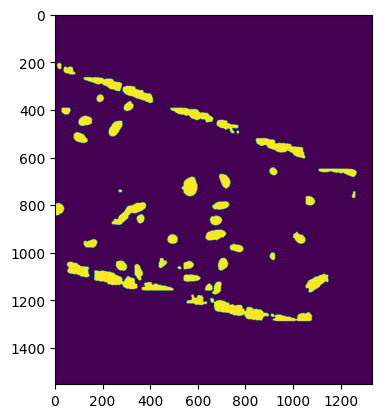

In [ ]:
## 4.2最新的predict全流程设置
# 设置参数
model_path = "models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth"  # 模型路径

# image_path = "dataset/Lucchi++/Test_In/mask0055.png"  # 测试图片路径
# mask_path = "dataset/Lucchi++/Test_Out/55.png"  # 真实掩码路径（如果有）

image_path = "dataset/Kasthuri++/Test_In/mask1049.png"  # 测试图片路径
mask_path = "dataset/Kasthuri++/Test_Out/mask1049.png"  # 真实掩码路径（如果有）


# image_path = "dataset/VNC/Test_In/16.tif"  # 测试图片路径
# mask_path = "dataset/VNC/Test_Out/16.png"  # 真实掩码路径（如果有）

save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小
stride = 128  # 步长

# 执行分割流程
pred_mask, metrics = segmentation_pipeline(
    model_path=model_path,
    image_path=image_path,
    mask_path=mask_path,
    save_dir=save_dir,
    patch_size=patch_size,
    stride=stride,
    value=-30, # value建议亮度设置低，会更显著，暂时不知原因
    alpha=1.0
)

if metrics:
    print(f"最终评估指标: IoU={metrics['IoU']:.4f}, Dice={metrics['Dice']:.4f}")
    
plt.imshow(pred_mask)
plt.show()

4.2.2版本的L=>K 效果不是很好，在35-40浮动，虽然大概的区域都识别到了，但是边缘上除了问题，我估计是L的边缘没有黑色区域导致的，因为K的边缘有黑色区域，且那些值是2，所以可能导致一些不对劲的地方。